In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ‚úÖ API Key
api_key = "-"

# ‚úÖ Ïû¨ÏãúÎèÑ Í∞ÄÎä•Ìïú ÏÑ∏ÏÖò Íµ¨ÏÑ±
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount("http://", HTTPAdapter(max_retries=retries))

# ‚úÖ Spot Ï†ïÎ≥¥ ÏàòÏßë
spot_url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/SpotInfo/1/1000/"
res = session.get(spot_url, timeout=10)
root = ET.fromstring(res.content)

spot_list = []
for row in root.findall("row"):
    spot_list.append({
        "spot_num": row.find("spot_num").text,
        "spot_name": row.find("spot_nm").text,
        "x": float(row.find("grs80tm_x").text),
        "y": float(row.find("grs80tm_y").text),
    })

spot_df = pd.DataFrame(spot_list)

# ‚úÖ 4Ïõî Ï£ºÎßê ÎÇ†Ïßú Î¶¨Ïä§Ìä∏
def get_weekends(year, month):
    weekends = []
    date = datetime(year, month, 1)
    while date.month == month:
        if date.weekday() >= 5:  # ÌÜ†ÏöîÏùº(5), ÏùºÏöîÏùº(6)
            weekends.append(date.strftime("%Y%m%d"))
        date += timedelta(days=1)
    return weekends

dates = get_weekends(2025, 4)
hours = [f"{i:02d}" for i in range(24)]

# ‚úÖ ÍµêÌÜµÎüâ ÏàòÏßë
vol_records = []
fail_logs = []

for date in dates:
    for hour in hours:
        for spot in spot_df["spot_num"]:
            url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/VolInfo/1/100/{spot}/{date}/{hour}/"
            try:
                r = session.get(url, timeout=10)
                root = ET.fromstring(r.content)

                for row in root.findall("row"):
                    vol_records.append({
                        "spot_num": row.find("spot_num").text,
                        "date": row.find("ymd").text,
                        "hour": row.find("hh").text,
                        "inout": row.find("io_type").text,
                        "lane": row.find("lane_num").text,
                        "volume": int(row.find("vol").text)
                    })
            except Exception as e:
                print(f"‚ùå ÏöîÏ≤≠ Ïã§Ìå®: {date} {hour} {spot} - {e}")
                fail_logs.append((date, hour, spot))

# ‚úÖ Í≤∞Í≥º Ï†ïÎ¶¨
vol_df = pd.DataFrame(vol_records)
print(f"‚úÖ ÏàòÏßë ÏôÑÎ£å: {len(vol_df)}Í±¥")
if fail_logs:
    print(f"‚ö†Ô∏è Ïã§Ìå® ÏöîÏ≤≠ Ïàò: {len(fail_logs)}")
    pd.DataFrame(fail_logs, columns=["date", "hour", "spot"]).to_csv("Ï£ºÎßê_ÏöîÏ≤≠Ïã§Ìå®.csv", index=False)

vol_df.to_csv("4_weekend.csv", index=False, encoding="utf-8-sig")


‚úÖ ÏàòÏßë ÏôÑÎ£å: 161027Í±¥


In [ ]:
import pandas as pd

vol_df= pd.read_csv("4_weekend.csv")
vol_df

spot_num      date  hour  inout  lane  volume
0          A-01  20250405     0      1     1     188
1          A-01  20250405     0      1     2     308
2          A-01  20250405     0      2     1     396
3          A-01  20250405     0      2     2     271
4          A-02  20250405     0      1     1     165
...         ...       ...   ...    ...   ...     ...
161022     F-09  20250427    23      2     2     121
161023     F-10  20250427    23      1     1     182
161024     F-10  20250427    23      1     2     173
161025     F-10  20250427    23      2     1     293
161026     F-10  20250427    23      2     2     392

[161027 rows x 6 columns]

In [10]:

spot_df= pd.read_csv("spot_with_address.csv")
spot_df

spot_num    spot_name              x              y         lon  \
0       A-01    ÏÑ±ÏÇ∞Î°ú(Í∏àÌôîÌÑ∞ÎÑê)  195489.000000  452136.000000  126.946835   
1       A-02    ÏÇ¨ÏßÅÎ°ú(ÏÇ¨ÏßÅÌÑ∞ÎÑê)  196756.776106  452546.638644  126.961184   
2       A-03  ÏûêÌïòÎ¨∏Î°ú(ÏûêÌïòÎ¨∏ÌÑ∞ÎÑê)  197216.855046  454350.990432  126.966385   
3       A-04   ÎåÄÏÇ¨Í¥ÄÎ°ú(ÏÇºÏ≤≠ÌÑ∞ÎÑê)  198648.893154  455200.108465  126.982598   
4       A-05     Ïú®Í≥°Î°ú(ÏïàÍµ≠Ïó≠)  198645.671347  452937.216603  126.982566   
..       ...          ...            ...            ...         ...   
134     F-06       Í≤ΩÎ∂ÄÍ≥†ÏÜçÎèÑÎ°ú  202107.000000  443264.000000  127.021724   
135     F-07        Î∂ÑÎãπÏàòÏÑúÎ°ú  207716.000000  444241.000000  127.085158   
136     F-08  Í∞ïÎÇ®ÏàúÌôòÎ°ú(Í¥ÄÏïÖÌÑ∞ÎÑê)  191832.000000  437667.000000  126.905601   
137     F-09     ÏÑúÎ∂ÄÍ∞ÑÏÑ†ÏßÄÌïòÎèÑÎ°ú  189706.000000  441044.000000  126.881529   
138     F-10     Ïã†ÏõîÏó¨ÏùòÏßÄÌïòÎèÑÎ°ú  187350.000000  447719.000000  126.854781   

           lat     Íµ¨    Îèô   ÏßÄÏó≠  
0    37.571502  ÏÑúÎåÄÎ¨∏Íµ¨  Î¥âÏõêÎèô  Î∂ÅÏÑúÎ∂Ä  
1    37.575207   Ï¢ÖÎ°úÍµ¨  Î¨¥ÏïÖÎèô  Î∂ÅÏÑúÎ∂Ä  
2    37.591465   Ï¢ÖÎ°úÍµ¨  Ï≤≠Ïö¥Îèô  Î∂ÅÏÑúÎ∂Ä  
3    37.599119   ÏÑ±Î∂ÅÍµ¨  ÏÑ±Î∂ÅÎèô  Î∂ÅÏÑúÎ∂Ä  
4    37.578731   Ï¢ÖÎ°úÍµ¨  ÏïàÍµ≠Îèô  Î∂ÅÏÑúÎ∂Ä  
..         ...   ...  ...  ...  
134  37.491575   ÏÑúÏ¥àÍµ¨  ÏÑúÏ¥àÎèô  ÎÇ®ÎèôÎ∂Ä  
135  37.500348   ÏÜ°ÌååÍµ¨  ÏÇºÏ†ÑÎèô  ÎÇ®ÎèôÎ∂Ä  
136  37.441111   Í∏àÏ≤úÍµ¨  ÏãúÌù•Îèô  ÎÇ®ÏÑúÎ∂Ä  
137  37.471517   Í∏àÏ≤úÍµ¨  Í∞ÄÏÇ∞Îèô  ÎÇ®ÏÑúÎ∂Ä  
138  37.531629   Í∞ïÏÑúÍµ¨  ÌôîÍ≥°Îèô  ÎÇ®ÏÑúÎ∂Ä  

[139 rows x 9 columns]

In [59]:
import pandas as pd

# ‚úÖ Î≥ëÌï©
merged_df = pd.merge(vol_df, spot_df, on="spot_num", how="left")

# ‚úÖ ÌïÑÏöîÌïú Ïó¥ ÏÑ†ÌÉù Î∞è Í≤∞Ï∏°Ïπò Ï†úÍ±∞ (ÏÑ†Ï†úÏ†Å Ï†ïÎ¶¨)
# merged_df = merged_df[["spot_num", "spot_name", "date", "hour", "inout", "volume", "Íµ¨", "Îèô", "ÏßÄÏó≠"]]
# merged_df.dropna(subset=["ÏßÄÏó≠", "volume"], inplace=True)

# ‚úÖ ÏßÄÏó≠Î≥Ñ ÌòºÏû°ÎèÑ ÏßëÍ≥Ñ (Ïú†ÏûÖ, Ïú†Ï∂ú Îî∞Î°ú)
region_gb = (
    merged_df.groupby(["date", "hour","Íµ¨", "Îèô", "ÏßÄÏó≠",  "spot_name", "inout"])[["volume"]]
    .sum()
    .reset_index()
    .rename(columns={"volume": "Ï¥ùÍµêÌÜµÎüâ"})
)

# ‚úÖ Ïú†ÏûÖ/Ïú†Ï∂ú Ìï¥ÏÑù Ïù¥Î¶Ñ Î∂ôÏù¥Í∏∞
region_gb["Íµ¨Î∂Ñ"] = region_gb["inout"].map({1: "Ïú†ÏûÖ", 2: "Ïú†Ï∂ú"})

# ‚úÖ ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï†ïÎ†¨
region_gb = region_gb.sort_values(by=["date", "hour", "ÏßÄÏó≠"])

# ‚úÖ ÏòàÏãú Ï†ÄÏû•
# region_gb.to_csv("ÏßÄÏó≠Î≥Ñ_ÏãúÍ∞ÑÎ≥Ñ_ÍµêÌÜµÎüâ.csv", index=False, encoding="utf-8-sig")
# print("‚úÖ Ï†ÄÏû• ÏôÑÎ£å: ÏßÄÏó≠Î≥Ñ_ÏãúÍ∞ÑÎ≥Ñ_ÍµêÌÜµÎüâ.csv")


In [15]:
region_gb

date  hour    Íµ¨    Îèô   ÏßÄÏó≠     spot_name  inout  Ï¥ùÍµêÌÜµÎüâ  Íµ¨Î∂Ñ
0      20250405     0  Í∞ïÎÇ®Íµ¨  ÏÇºÏÑ±Îèô  ÎÇ®ÎèôÎ∂Ä     ÌÖåÌó§ÎûÄÎ°ú(ÏÑ†Î¶âÏó≠)      1   942  Ïú†ÏûÖ
1      20250405     0  Í∞ïÎÇ®Íµ¨  ÏÇºÏÑ±Îèô  ÎÇ®ÎèôÎ∂Ä     ÌÖåÌó§ÎûÄÎ°ú(ÏÑ†Î¶âÏó≠)      2  1013  Ïú†Ï∂ú
2      20250405     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä  Î∞§Í≥†Í∞úÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      1   177  Ïú†ÏûÖ
3      20250405     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä  Î∞§Í≥†Í∞úÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      2   155  Ïú†Ï∂ú
4      20250405     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä   ÌóåÎ¶âÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      1   330  Ïú†ÏûÖ
...         ...   ...  ...  ...  ...           ...    ...   ...  ..
49479  20250427    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑ∏Ï¢ÖÎåÄÎ°ú(ÏÑúÏö∏Ïó≠)      2   655  Ïú†Ï∂ú
49480  20250427    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä      Ïπ†Ìå®Î°ú(Ïà≠Î°ÄÎ¨∏)      1    19  Ïú†ÏûÖ
49481  20250427    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä      Ïπ†Ìå®Î°ú(Ïà≠Î°ÄÎ¨∏)      2   480  Ïú†Ï∂ú
49488  20250427    23   Ï§ëÍµ¨   Ï†ïÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑúÏÜåÎ¨∏Î°ú(ÏãúÏ≤≠Ïó≠)      1   550  Ïú†ÏûÖ
49489  20250427    23   Ï§ëÍµ¨   Ï†ïÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑúÏÜåÎ¨∏Î°ú(ÏãúÏ≤≠Ïó≠)      2   444  Ïú†Ï∂ú

[49500 rows x 9 columns]

In [ ]:
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = region_gb
# ÎÇ†ÏßúÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ïª¨Îüº Ï∂îÍ∞Ä
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]


# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
region_summary = weekend_df.groupby(["weekday", "ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
region_summary = region_summary.sort_values(["weekday", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[True, False])

# ÏöîÏïΩ Í≤∞Í≥º ÌôïÏù∏
print(region_summary)


    weekday   ÏßÄÏó≠     Ï¥ùÍµêÌÜµÎüâ
1  Saturday  ÎÇ®ÏÑúÎ∂Ä  9844193
0  Saturday  ÎÇ®ÎèôÎ∂Ä  9402077
3  Saturday  Î∂ÅÏÑúÎ∂Ä  7562835
2  Saturday  Î∂ÅÎèôÎ∂Ä  7203345
5    Sunday  ÎÇ®ÏÑúÎ∂Ä  8851271
4    Sunday  ÎÇ®ÎèôÎ∂Ä  8382275
7    Sunday  Î∂ÅÏÑúÎ∂Ä  7007752
6    Sunday  Î∂ÅÎèôÎ∂Ä  6625298


In [38]:
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = region_gb

# ÎÇ†ÏßúÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ïª¨Îüº Ï∂îÍ∞Ä (ÏòÅÏñ¥Î°ú)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# ÏòÅÏñ¥ -> ÌïúÍ∏Ä ÏöîÏùº Î≥ÄÌôò
day_map = {
    "Monday": "ÏõîÏöîÏùº",
    "Tuesday": "ÌôîÏöîÏùº",
    "Wednesday": "ÏàòÏöîÏùº",
    "Thursday": "Î™©ÏöîÏùº",
    "Friday": "Í∏àÏöîÏùº",
    "Saturday": "ÌÜ†ÏöîÏùº",
    "Sunday": "ÏùºÏöîÏùº"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["ÌÜ†ÏöîÏùº", "ÏùºÏöîÏùº"])]

# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
region_summary = weekend_df.groupby(["weekday", "ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[False, False])

# ÏöîÏïΩ Í≤∞Í≥º ÌôïÏù∏
print(region_summary)


  weekday   ÏßÄÏó≠    Ï¥ùÍµêÌÜµÎüâ
4     ÌÜ†ÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  1522.0
6     ÌÜ†ÏöîÏùº  Î∂ÅÎèôÎ∂Ä  1184.5
5     ÌÜ†ÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä   915.5
7     ÌÜ†ÏöîÏùº  Î∂ÅÏÑúÎ∂Ä   861.0
0     ÏùºÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  1289.0
2     ÏùºÏöîÏùº  Î∂ÅÎèôÎ∂Ä  1016.0
3     ÏùºÏöîÏùº  Î∂ÅÏÑúÎ∂Ä   794.0
1     ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä   772.0


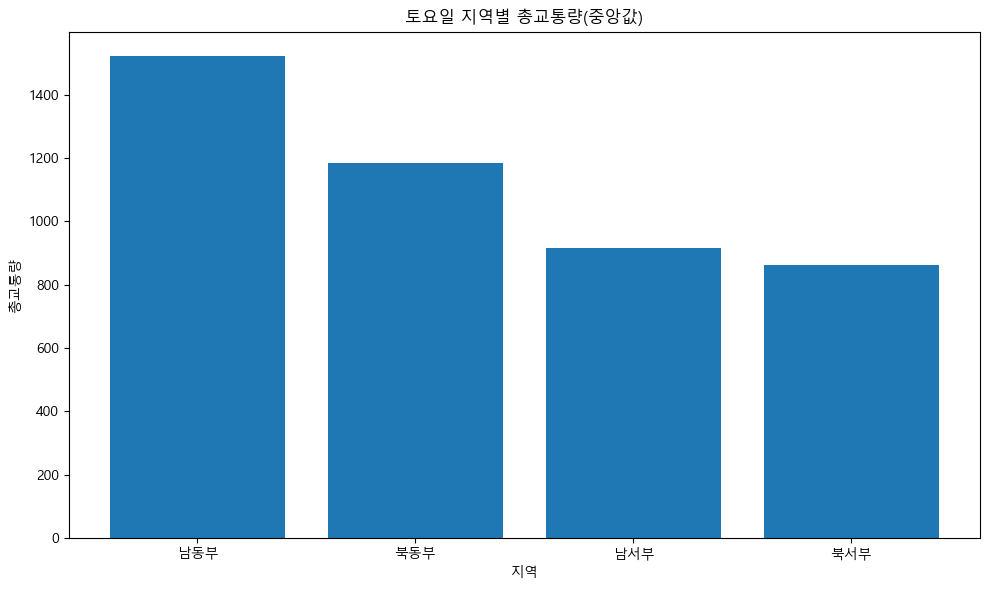

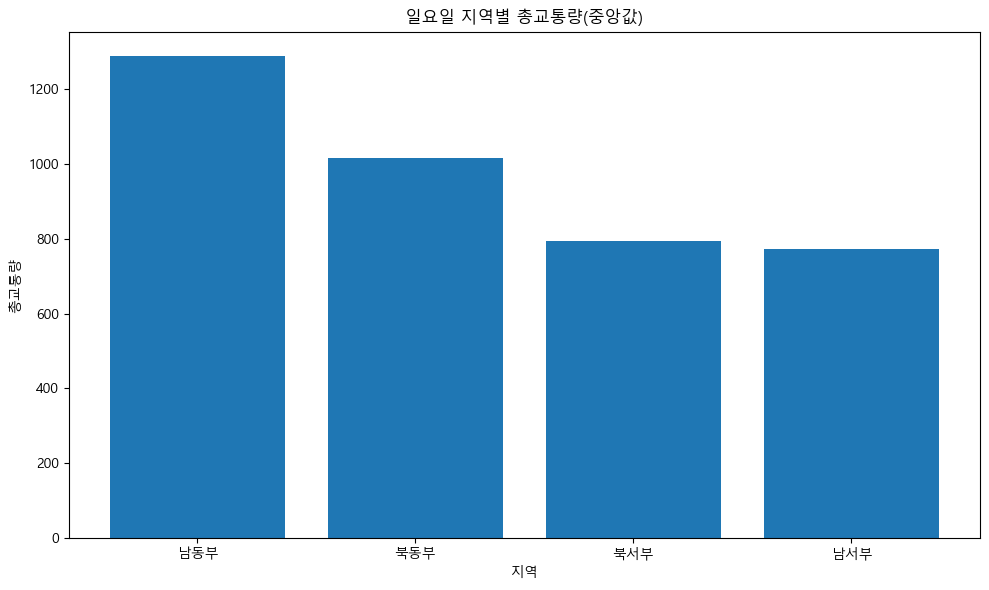

In [39]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# (ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ - ÌïÑÏöîÏãú Ìè∞Ìä∏ ÏßÄÏ†ï)
# fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')  # Î¶¨ÎàÖÏä§ ÏòàÏãú
plt.rc('font', family='Malgun Gothic')  # ÏúàÎèÑÏö∞Îäî Î≥¥ÌÜµ 'Malgun Gothic'
plt.rc('axes', unicode_minus=False)     # ÎßàÏù¥ÎÑàÏä§ Íπ®Ïßê Î∞©ÏßÄ

# ÏöîÏùºÎ≥ÑÎ°ú ÎÇòÎà†ÏÑú Í∑∏Î¶¨Í∏∞
weekdays = ["ÌÜ†ÏöîÏùº", "ÏùºÏöîÏùº"]

for day in weekdays:
    day_data = region_summary[region_summary["weekday"] == day]
    plt.figure(figsize=(10, 6))
    plt.bar(day_data["ÏßÄÏó≠"], day_data["Ï¥ùÍµêÌÜµÎüâ"])
    plt.title(f"{day} ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ(Ï§ëÏïôÍ∞í)")
    plt.xlabel("ÏßÄÏó≠")
    plt.ylabel("Ï¥ùÍµêÌÜµÎüâ")
    # plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    ÏßÄÏó≠      Ï¥ùÍµêÌÜµÎüâ
1  ÎÇ®ÏÑúÎ∂Ä  18695464
0  ÎÇ®ÎèôÎ∂Ä  17784352
3  Î∂ÅÏÑúÎ∂Ä  14570587
2  Î∂ÅÎèôÎ∂Ä  13828643


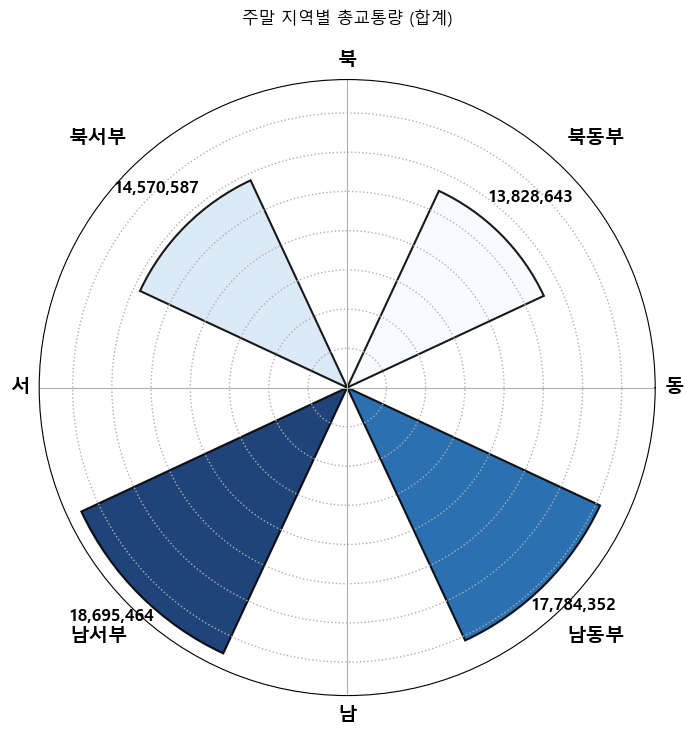

'\nüîç Ïôú Ïù¥Îü∞ Í≤∞Í≥ºÍ∞Ä ÎÇòÏò¨Íπå?\n‚úÖ Ï§ëÏïôÍ∞í(median)\n\nÎã®ÏàúÌûà Î™®Îì† Í∞íÎì§ÏùÑ ÌÅ¨Í∏∞ÏàúÏúºÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Îî± Ï§ëÍ∞Ñ Í∞í.\n\nÍ∑πÎã®Ï†ÅÏúºÎ°ú ÌÅ∞ Í∞í(Ïù¥ÏÉÅÏπò)Ïù¥ ÏûàÎçîÎùºÎèÑ Í∑∏ ÏòÅÌñ•ÏùÄ Í±∞Ïùò ÏóÜÏùå.\n\nÏ¶â, ÏùºÏÉÅÏ†ÅÏù∏ "ÌèâÎ≤îÌïú" ÌùêÎ¶ÑÏùò ÎåÄÌëúÍ∞íÏùÑ Î≥¥Ïó¨Ï§å.\n\n‚úÖ Ï¥ùÌï©(sum)\n\nÎ™®Îì† Í∞íÏùÑ ÎçîÌïú Í∞íÏù¥Í∏∞ ÎïåÎ¨∏Ïóê\n\nÍ∞íÏù¥ ÎÜíÏùÄ ÎÇ†Ïù¥ Î™á Î≤àÎßå ÎÇòÏôÄÎèÑ Ï†ÑÏ≤¥ Ìï©Í≥ÑÎ•º ÌÅ¨Í≤å ÎßåÎì¶.\n\nÏ¶â, ÌäπÏ†ï Í∏∞Í∞Ñ ÎèôÏïà Ï†ÑÏ≤¥ Í∑úÎ™®(ÎàÑÏ†Å)Î•º Î≥¥Ïó¨Ï§å.\n\nüìä Í∑∏ÎûòÏÑú\nÎÇ®ÎèôÎ∂Ä\n‚Üí ÌèâÏÉÅÏãú Ìä∏ÎûòÌîΩ(Ï§ëÏïôÍ∞í)Ïù¥ Ï†úÏùº ÎÜíÏïÑÏÑú ‚ÄúÌèâÍ∑†Ï†ÅÏúºÎ°ú Î∂êÎπÑÎäî‚Äù Í≥≥.\n\nÎÇ®ÏÑúÎ∂Ä\n‚Üí Î©∞Ïπ† ÍµêÌÜµÎüâÏù¥ ÏóÑÏ≤≠ ÎÜíÏïÑÏÑú ÎàÑÏ†ÅÌï©Ïù¥ Îçî Ïª§ÏßÑ Í≤ÉÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº.\n(ex: ÎåÄÌòï ÌñâÏÇ¨, Í≥µÏÇ¨ Ïö∞Ìöå Îì± ÌäπÏ†ï Í∏∞Í∞ÑÏóê Ìä∏ÎûòÌîΩ Í∏âÏ¶ù)\n'

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = region_gb

# ÎÇ†ÏßúÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ïª¨Îüº Ï∂îÍ∞Ä (ÏòÅÏñ¥Î°ú)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# ÏòÅÏñ¥ -> ÌïúÍ∏Ä ÏöîÏùº Î≥ÄÌôò
day_map = {
    "Monday": "ÏõîÏöîÏùº",
    "Tuesday": "ÌôîÏöîÏùº",
    "Wednesday": "ÏàòÏöîÏùº",
    "Thursday": "Î™©ÏöîÏùº",
    "Friday": "Í∏àÏöîÏùº",
    "Saturday": "ÌÜ†ÏöîÏùº",
    "Sunday": "ÏùºÏöîÏùº"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["ÌÜ†ÏöîÏùº", "ÏùºÏöîÏùº"])]

# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
region_summary = weekend_df.groupby(["ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
region_summary = region_summary.sort_values([ "Ï¥ùÍµêÌÜµÎüâ"], ascending=[ False])

# ÏöîÏïΩ Í≤∞Í≥º ÌôïÏù∏
print(region_summary)

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
data = region_summary
angle_map = {'ÎÇ®ÎèôÎ∂Ä': 315, 'Î∂ÅÎèôÎ∂Ä': 45, 'Î∂ÅÏÑúÎ∂Ä': 135, 'ÎÇ®ÏÑúÎ∂Ä': 225}
angles = [np.deg2rad(angle_map[area]) for area in data['ÏßÄÏó≠']]
traffic = data['Ï¥ùÍµêÌÜµÎüâ']
norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# ÎßâÎåÄ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞ (ÌÖåÎëêÎ¶¨ Ï∂îÍ∞Ä)
for angle, height, norm_val in zip(angles, traffic, norm_traffic):
    ax.bar(angle, height, width=np.deg2rad(40), 
           color=plt.cm.Blues(norm_val), 
           edgecolor='black', linewidth=1.5, 
           align='center', alpha=0.9)

# ÎèôÏÑúÎÇ®Î∂Å ÎùºÎ≤®
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['Îèô', 'Î∂Å', 'ÏÑú', 'ÎÇ®'], fontsize=14, fontweight='bold')

# ÎåÄÍ∞ÅÏÑ† Î∞©ÏúÑ ÎùºÎ≤®
for area, angle_deg in angle_map.items():
    angle_rad = np.deg2rad(angle_deg)
    r = max(traffic) * 1.2
    ax.text(angle_rad, r, area, ha='center', va='center', 
            fontsize=14, color='black', fontweight='bold')

# ÎßâÎåÄ ÏúÑÏóê Í∞í ÌëúÏãú
for angle, height in zip(angles, traffic):
    ax.text(angle, height + (max(traffic)*0.14), f'{height:,.0f}', 
            ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Î∞òÏßÄÎ¶Ñ ÎààÍ∏à Ï†êÏÑ†ÏúºÎ°ú
ax.yaxis.grid(True, linestyle=':', linewidth=1)
ax.set_yticklabels([])

plt.title("Ï£ºÎßê ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ (Ìï©Í≥Ñ)", pad=20)
plt.show()
'''
üîç Ïôú Ïù¥Îü∞ Í≤∞Í≥ºÍ∞Ä ÎÇòÏò¨Íπå?
‚úÖ Ï§ëÏïôÍ∞í(median)

Îã®ÏàúÌûà Î™®Îì† Í∞íÎì§ÏùÑ ÌÅ¨Í∏∞ÏàúÏúºÎ°ú ÎÇòÏó¥ÌñàÏùÑ Îïå Îî± Ï§ëÍ∞Ñ Í∞í.

Í∑πÎã®Ï†ÅÏúºÎ°ú ÌÅ∞ Í∞í(Ïù¥ÏÉÅÏπò)Ïù¥ ÏûàÎçîÎùºÎèÑ Í∑∏ ÏòÅÌñ•ÏùÄ Í±∞Ïùò ÏóÜÏùå.

Ï¶â, ÏùºÏÉÅÏ†ÅÏù∏ "ÌèâÎ≤îÌïú" ÌùêÎ¶ÑÏùò ÎåÄÌëúÍ∞íÏùÑ Î≥¥Ïó¨Ï§å.

‚úÖ Ï¥ùÌï©(sum)

Î™®Îì† Í∞íÏùÑ ÎçîÌïú Í∞íÏù¥Í∏∞ ÎïåÎ¨∏Ïóê

Í∞íÏù¥ ÎÜíÏùÄ ÎÇ†Ïù¥ Î™á Î≤àÎßå ÎÇòÏôÄÎèÑ Ï†ÑÏ≤¥ Ìï©Í≥ÑÎ•º ÌÅ¨Í≤å ÎßåÎì¶.

Ï¶â, ÌäπÏ†ï Í∏∞Í∞Ñ ÎèôÏïà Ï†ÑÏ≤¥ Í∑úÎ™®(ÎàÑÏ†Å)Î•º Î≥¥Ïó¨Ï§å.

üìä Í∑∏ÎûòÏÑú
ÎÇ®ÎèôÎ∂Ä
‚Üí ÌèâÏÉÅÏãú Ìä∏ÎûòÌîΩ(Ï§ëÏïôÍ∞í)Ïù¥ Ï†úÏùº ÎÜíÏïÑÏÑú ‚ÄúÌèâÍ∑†Ï†ÅÏúºÎ°ú Î∂êÎπÑÎäî‚Äù Í≥≥.

ÎÇ®ÏÑúÎ∂Ä
‚Üí Î©∞Ïπ† ÍµêÌÜµÎüâÏù¥ ÏóÑÏ≤≠ ÎÜíÏïÑÏÑú ÎàÑÏ†ÅÌï©Ïù¥ Îçî Ïª§ÏßÑ Í≤ÉÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº.
(ex: ÎåÄÌòï ÌñâÏÇ¨, Í≥µÏÇ¨ Ïö∞Ìöå Îì± ÌäπÏ†ï Í∏∞Í∞ÑÏóê Ìä∏ÎûòÌîΩ Í∏âÏ¶ù)
'''

    ÏßÄÏó≠    Ï¥ùÍµêÌÜµÎüâ
0  ÎÇ®ÎèôÎ∂Ä  1409.0
2  Î∂ÅÎèôÎ∂Ä  1103.0
1  ÎÇ®ÏÑúÎ∂Ä   845.0
3  Î∂ÅÏÑúÎ∂Ä   826.5


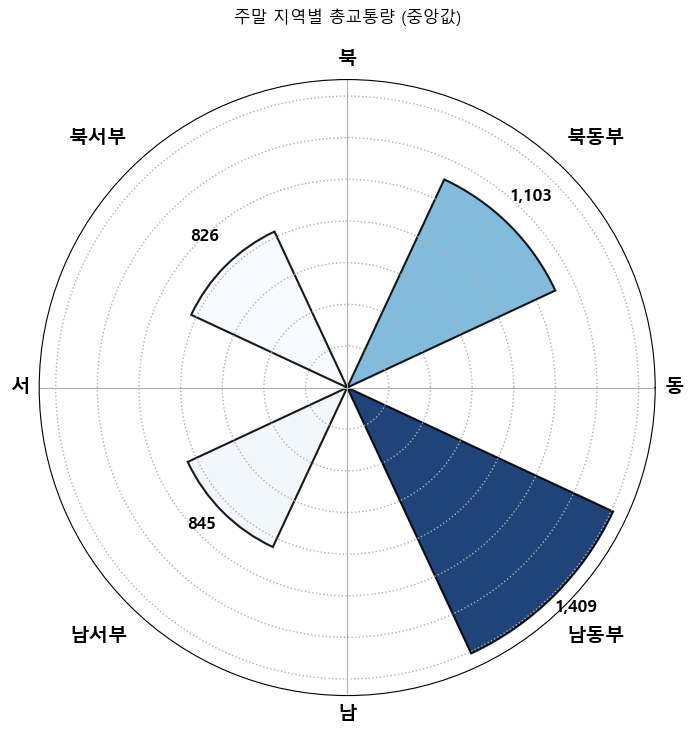

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = region_gb

# ÎÇ†ÏßúÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ïª¨Îüº Ï∂îÍ∞Ä (ÏòÅÏñ¥Î°ú)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# ÏòÅÏñ¥ -> ÌïúÍ∏Ä ÏöîÏùº Î≥ÄÌôò
day_map = {
    "Monday": "ÏõîÏöîÏùº",
    "Tuesday": "ÌôîÏöîÏùº",
    "Wednesday": "ÏàòÏöîÏùº",
    "Thursday": "Î™©ÏöîÏùº",
    "Friday": "Í∏àÏöîÏùº",
    "Saturday": "ÌÜ†ÏöîÏùº",
    "Sunday": "ÏùºÏöîÏùº"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["ÌÜ†ÏöîÏùº", "ÏùºÏöîÏùº"])]

# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
region_summary = weekend_df.groupby(["ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].median().reset_index()
region_summary = region_summary.sort_values([ "Ï¥ùÍµêÌÜµÎüâ"], ascending=[ False])

# ÏöîÏïΩ Í≤∞Í≥º ÌôïÏù∏
print(region_summary)

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
data = region_summary
angle_map = {'ÎÇ®ÎèôÎ∂Ä': 315, 'Î∂ÅÎèôÎ∂Ä': 45, 'Î∂ÅÏÑúÎ∂Ä': 135, 'ÎÇ®ÏÑúÎ∂Ä': 225}
angles = [np.deg2rad(angle_map[area]) for area in data['ÏßÄÏó≠']]
traffic = data['Ï¥ùÍµêÌÜµÎüâ']
norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# ÎßâÎåÄ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞ (ÌÖåÎëêÎ¶¨ Ï∂îÍ∞Ä)
for angle, height, norm_val in zip(angles, traffic, norm_traffic):
    ax.bar(angle, height, width=np.deg2rad(40), 
           color=plt.cm.Blues(norm_val), 
           edgecolor='black', linewidth=1.5, 
           align='center', alpha=0.9)

# ÎèôÏÑúÎÇ®Î∂Å ÎùºÎ≤®
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['Îèô', 'Î∂Å', 'ÏÑú', 'ÎÇ®'], fontsize=14, fontweight='bold')

# ÎåÄÍ∞ÅÏÑ† Î∞©ÏúÑ ÎùºÎ≤®
for area, angle_deg in angle_map.items():
    angle_rad = np.deg2rad(angle_deg)
    r = max(traffic) * 1.2
    ax.text(angle_rad, r, area, ha='center', va='center', 
            fontsize=14, color='black', fontweight='bold')

# ÎßâÎåÄ ÏúÑÏóê Í∞í ÌëúÏãú
for angle, height in zip(angles, traffic):
    ax.text(angle, height + (max(traffic)*0.1), f'{height:,.0f}', 
            ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Î∞òÏßÄÎ¶Ñ ÎààÍ∏à Ï†êÏÑ†ÏúºÎ°ú
ax.yaxis.grid(True, linestyle=':', linewidth=1)
ax.set_yticklabels([])

plt.title("Ï£ºÎßê ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ (Ï§ëÏïôÍ∞í)", pad=20)
plt.show()

In [ ]:
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = region_gb

# ÎÇ†ÏßúÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ïª¨Îüº Ï∂îÍ∞Ä (ÏòÅÏñ¥Î°ú)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# ÏòÅÏñ¥ -> ÌïúÍ∏Ä ÏöîÏùº Î≥ÄÌôò
day_map = {
    "Monday": "ÏõîÏöîÏùº",
    "Tuesday": "ÌôîÏöîÏùº",
    "Wednesday": "ÏàòÏöîÏùº",
    "Thursday": "Î™©ÏöîÏùº",
    "Friday": "Í∏àÏöîÏùº",
    "Saturday": "ÌÜ†ÏöîÏùº",
    "Sunday": "ÏùºÏöîÏùº"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["ÌÜ†ÏöîÏùº", "ÏùºÏöîÏùº"])]

# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
region_summary = weekend_df.groupby(["weekday", "ÏßÄÏó≠",'Íµ¨'])["Ï¥ùÍµêÌÜµÎüâ"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[False, False])

# ÏöîÏïΩ Í≤∞Í≥º ÌôïÏù∏
print(region_summary)


   weekday   ÏßÄÏó≠    Íµ¨    Ï¥ùÍµêÌÜµÎüâ
65     ÌÜ†ÏöîÏùº  Î∂ÅÎèôÎ∂Ä  Íµ¨Î¶¨Ïãú  3767.0
44     ÌÜ†ÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  Í≥ºÏ≤úÏãú  3174.5
57     ÌÜ†ÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  ÎßàÌè¨Íµ¨  2603.0
49     ÌÜ†ÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  Ïö©ÏÇ∞Íµ¨  2374.0
78     ÌÜ†ÏöîÏùº  Î∂ÅÏÑúÎ∂Ä  ÎßàÌè¨Íµ¨  2341.0
..     ...  ...  ...     ...
41     ÏùºÏöîÏùº  Î∂ÅÏÑúÎ∂Ä   Ï§ëÍµ¨   369.0
17     ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  ÏÑúÏ¥àÍµ¨   365.0
22     ÏùºÏöîÏùº  Î∂ÅÎèôÎ∂Ä  Í¥ëÏßÑÍµ¨   351.0
1      ÏùºÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  Í∞ïÎèôÍµ¨   330.0
11     ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  Í¥ëÎ™ÖÏãú    64.0

[84 rows x 4 columns]


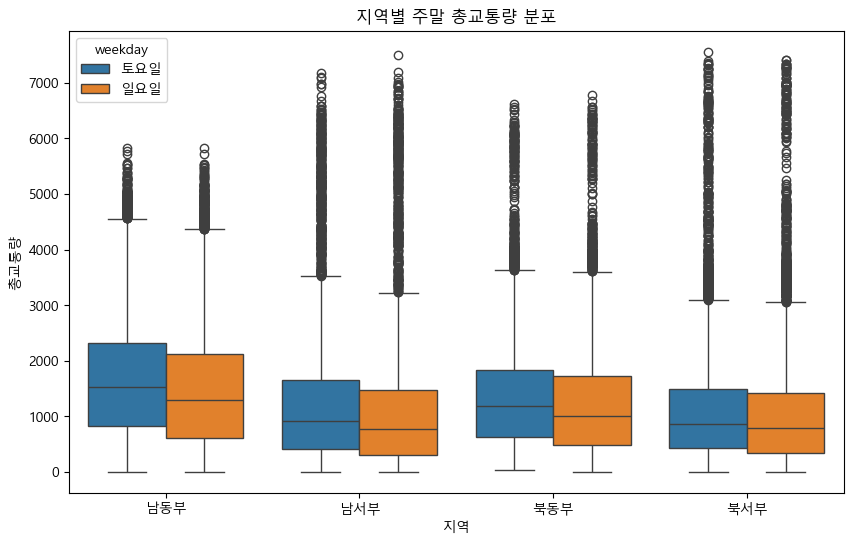

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x='ÏßÄÏó≠', y='Ï¥ùÍµêÌÜµÎüâ', hue='weekday', data=df)
plt.title("ÏßÄÏó≠Î≥Ñ Ï£ºÎßê Ï¥ùÍµêÌÜµÎüâ Î∂ÑÌè¨")
plt.ylabel("Ï¥ùÍµêÌÜµÎüâ")
plt.show()
'''
üîç Ïôú Î∞ïÏä§ÌîåÎ°ØÏóê Ïù¥ÏÉÅÏπòÍ∞Ä Í∑∏Î†áÍ≤å ÎßéÏù¥ Ï∞çÌûàÎäîÍ∞Ä?
1Ô∏è‚É£ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏõêÎûò Í∑πÎã®Ï†ÅÏúºÎ°ú ÏπòÏö∞Ï≥ê ÏûàÏñ¥ÏÑú
ÍµêÌÜµÎüâ Îç∞Ïù¥ÌÑ∞Îäî ÌùîÌûà long-tail (Ïö∞Ï∏°ÏúºÎ°ú Í∏¥ Íº¨Î¶¨) Î∂ÑÌè¨Î•º Í∞ÄÏßê.

ÎåÄÎ∂ÄÎ∂Ñ ÏßÄÏ†êÏùÄ ÌèâÏÜåÏóê ÎπÑÍµêÏ†Å ÎÇÆÏùÄ ÍµêÌÜµÎüâ

ÏùºÎ∂Ä ÏßÄÏ†êÎßå ÌäπÏ†ï ÏãúÍ∞ÑÎåÄÏóê ÏóÑÏ≤≠ÎÇòÍ≤å Î™∞Î¶º (ex. ÌÅ∞ ÎèÑÎ°ú, ÏûÖÍµ¨, ÌÑ∞ÎÑê, IC)

Í∑∏ÎûòÏÑú Q3 + 1.5 * IQRÏùÑ ÎÑòÎäî Í∞íÏù¥ Îã§ Ïù¥ÏÉÅÏπòÎ°ú Ïû°Ìûò.
üöó ÍµêÌÜµ Îç∞Ïù¥ÌÑ∞ÎùºÏÑú ÌäπÌûà Ïã¨Ìï®

ÍµêÌÜµ Îç∞Ïù¥ÌÑ∞Îäî ÌèâÏÜåÏóî ÎÇÆÎã§Í∞Ä ÌäπÏ†ï ÏãúÍ∞Ñ, ÌäπÏ†ï Íµ¨Í∞ÑÏóê Ìôï Î™∞Î¶º.

Ïòà: Ïõî~Í∏à Ï∂úÍ∑ºÏãúÍ∞Ñ, ÌÜ†/Ïùº ÎåÄÌòï ÏáºÌïëÎ™∞ Í∑ºÏ≤ò ‚Üí Î™áÎßåÎåÄ Î™∞Î†§ÏÑú Í∑πÎã®Ï†Å Ìä∏ÎûòÌîΩ Î∞úÏÉù.

ÏûêÏó∞Ïä§ÎüΩÍ≤å Î∞ïÏä§ÌîåÎ°ØÏóêÏÑúÎäî Îã§ ÎèôÍ∑∏ÎùºÎØ∏Î°ú ÌëúÏãúÎê®.

üí° Í∑∏ÎûòÏÑú Ïñ¥ÎñªÍ≤å Î≥¥ÎÇò?
Ïù¥ÏÉÅÏπòÎ•º Ïà®Í∏∞Îäî boxplot (showfliers=False) ÏúºÎ°ú Ï§ëÏúÑÍ∞íÍ≥º IQRÎßå Î≥¥Í≥†,

Îî∞Î°ú ÌûàÏä§ÌÜ†Í∑∏Îû® / Ïª§ÎÑêÎ∞ÄÎèÑ (sns.kdeplot) ÏúºÎ°ú Ï†ÑÏ≤¥ Î∂ÑÌè¨Î•º Î¥êÏÑú ÌôïÏù∏,

ÌòπÏùÄ Î°úÍ∑∏Ïä§ÏºÄÏùºÎ°ú Ï§ÑÏó¨ÏÑú Ïò§Î•∏Ï™Ω Í∏¥ Íº¨Î¶¨ÍπåÏßÄ ÌïúÎààÏóê Î≥¥Í≤å Ìï®.

'''

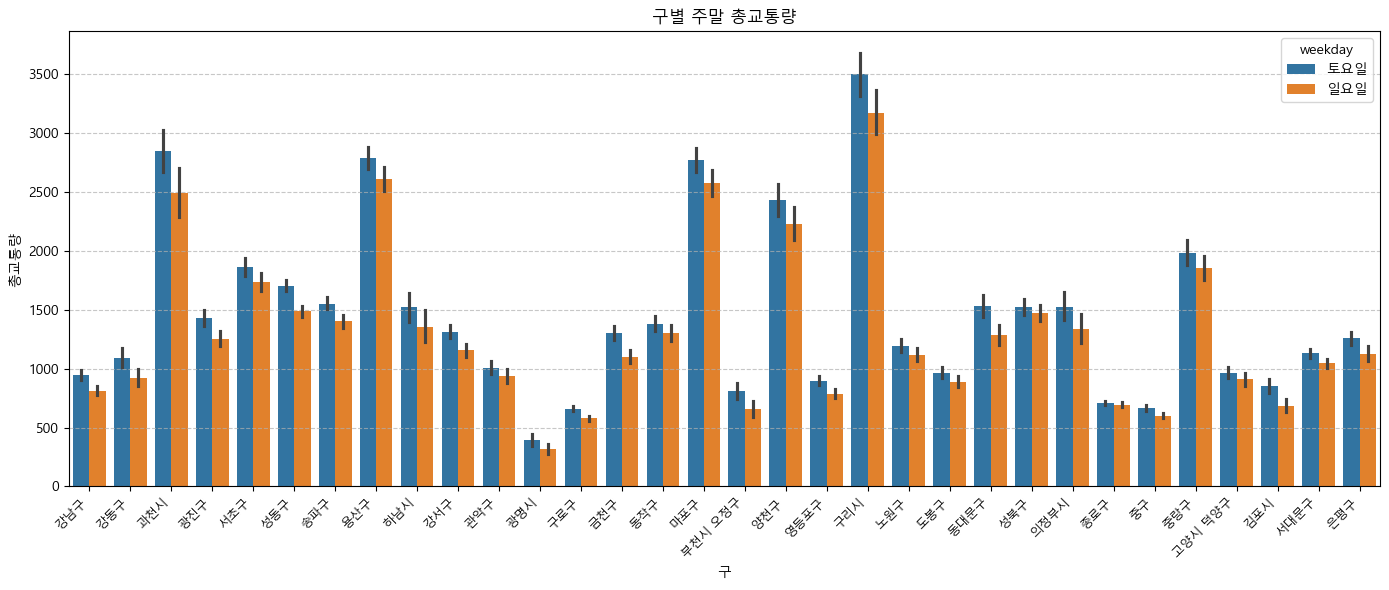

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
ax = sns.barplot(x='Íµ¨', y='Ï¥ùÍµêÌÜµÎüâ', hue='weekday', data=df)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title("Íµ¨Î≥Ñ Ï£ºÎßê Ï¥ùÍµêÌÜµÎüâ")
plt.tight_layout()

# yÏ∂ï Ïã§ÏÑ† (Í∞ÄÎ°ú Í∑∏Î¶¨Îìú)
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.7)

plt.show()
'''
‚úÖ ÏÑúÏö∏ ÍµêÌÜµÎüâ API (SpotInfo)
SpotInfo Îäî ÏÑúÏö∏Ïãú ÍµêÌÜµÎüâ Ï∏°Ï†ïÏÜå Îç∞Ïù¥ÌÑ∞Ïù∏Îç∞

ÏÑúÏö∏ ÍµêÌÜµÎüâÏùÄ ÏÑúÏö∏ÏãúÏ≤≠ Í¥ÄÌï† Ï∏°Ï†ïÏÜåÎßå ÏûàÎäî Í≤å ÏïÑÎãàÏïº.

ÏÑúÏö∏Ïóê Ïú†ÏûÖ¬∑Ïú†Ï∂úÎêòÎäî ÍµêÌÜµÏùÑ ÌååÏïÖÌïòÍ∏∞ ÏúÑÌï¥
ÏÑúÏö∏ Ï£ºÎ≥Ä(Ïù∏Ï†ë Í≤ΩÍ∏∞ÎèÑ) ÎèÑÎ°úÏóêÎèÑ Ï∏°Ï†ïÏÜåÎ•º ÏÑ§ÏπòÌï®.

Í∑∏ÎûòÏÑú Î∂ÄÏ≤ú, Í≥†Ïñë, Í¥ëÎ™Ö Îì±Ïù¥ ÎÇòÏò¥.
(ÏÑúÏö∏ ÏßÑÏûÖ Í¥ÄÎ¨∏Ïù∏ ÍπÄÌè¨, Í≥†Ïñë Ï™ΩÏóê Ï∏°Ï†ïÏÜå ÎßéÏù¥ ÏûàÏùå.)

Ï¶â ÌñâÏ†ïÍµ¨Ïó≠ÏÉÅ Í≤ΩÍ∏∞ÎèÑÎùºÎèÑ, ÏÑúÏö∏ Ïú†ÏûÖÎüâÏùÑ Ï∏°Ï†ïÌïòÍ∏∞ ÏúÑÌï¥ ÏÑ§ÏπòÎêú Ï∏°Ï†ïÏÜåÎùºÏÑú
ÏÑúÏö∏ ÍµêÌÜµÎüâ ÌÜµÍ≥ÑÏóê Í∞ôÏù¥ Ìè¨Ìï®Îê®.


üîç Í≥ºÏ≤úÏãúÏùò ÌäπÏù¥Ï†ê
Í≥ºÏ≤úÏãúÎäî ÏûëÏùÄ ÎèÑÏãúÎùºÏÑú ÌñâÏ†ïÍµ¨Ïó≠ÏÉÅ 'Íµ¨'Í∞Ä ÏóÜÏùå.

Íµ¨ Îã®ÏúÑÎäî Ïù∏Íµ¨Í∞Ä ÎßéÍ≥† Î©¥Ï†ÅÏù¥ ÌÅ∞ Í¥ëÏó≠ÏãúÎÇò ÌäπÎ≥ÑÏãú(ÏÑúÏö∏, Î∂ÄÏÇ∞, ÎåÄÍµ¨‚Ä¶)ÏóêÎßå Ï°¥Ïû¨.

Í≥ºÏ≤úÏãú Í∞ôÏùÄ **Í≤ΩÍ∏∞ÎèÑ Í∏∞Ï¥àÏûêÏπòÎã®Ï≤¥(Ïãú)**Îäî Íµ¨ ÏóÜÏù¥ Î∞îÎ°ú ÎèôÏúºÎ°ú Íµ¨ÏÑ±Îê®.

üîç ÍπÄÌè¨ÏãúÎèÑ Ïôú Íµ¨Í∞Ä ÏóÜÏùÑÍπå?
ÍπÄÌè¨ÏãúÎäî Í≤ΩÍ∏∞ÎèÑ Í∏∞Ï¥àÏûêÏπòÎã®Ï≤¥(Ïãú) ÎùºÏÑú Íµ¨Í∞Ä ÏóÜÏùå.

Ï¶â Í≥ºÏ≤úÏãú, Î∂ÄÏ≤úÏãú, Í≥†ÏñëÏãú, ÍπÄÌè¨Ïãú, Í¥ëÎ™ÖÏãú, ÏùòÏ†ïÎ∂ÄÏãú... Î™®Îëê ÎèôÏùº.

Ïù¥Îü∞ ÎèÑÎÇ¥ ÏùºÎ∞ò ÏãúÎì§ÏùÄ ÌñâÏ†ïÍµ¨Ïó≠Ïù¥ Ïãú ‚Üí Îèô Íµ¨Ï°∞ÏßÄ
Ïãú ‚Üí Íµ¨ ‚Üí Îèô Íµ¨Ï°∞Í∞Ä ÏïÑÎãò.

'''

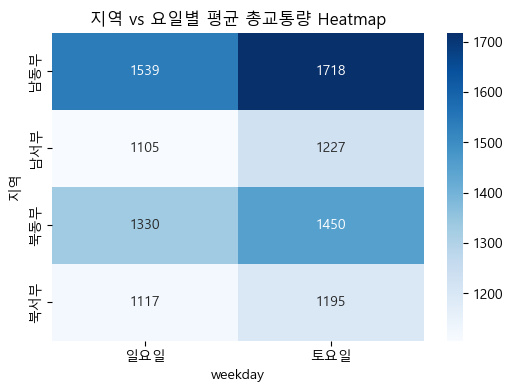

In [78]:
pivot = df.pivot_table(index='ÏßÄÏó≠', columns='weekday', values='Ï¥ùÍµêÌÜµÎüâ', aggfunc='mean')

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("ÏßÄÏó≠ vs ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Ï¥ùÍµêÌÜµÎüâ Heatmap")
plt.show()


In [127]:
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = region_gb

# ÎÇ†ÏßúÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ïª¨Îüº Ï∂îÍ∞Ä (ÏòÅÏñ¥Î°ú)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# ÏòÅÏñ¥ -> ÌïúÍ∏Ä ÏöîÏùº Î≥ÄÌôò
day_map = {
    "Monday": "ÏõîÏöîÏùº",
    "Tuesday": "ÌôîÏöîÏùº",
    "Wednesday": "ÏàòÏöîÏùº",
    "Thursday": "Î™©ÏöîÏùº",
    "Friday": "Í∏àÏöîÏùº",
    "Saturday": "ÌÜ†ÏöîÏùº",
    "Sunday": "ÏùºÏöîÏùº"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["ÌÜ†ÏöîÏùº", "ÏùºÏöîÏùº"])]

# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
region_summary = weekend_df.groupby(["weekday", 'Íµ¨'])["Ï¥ùÍµêÌÜµÎüâ"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[False, False])

# ÏöîÏïΩ Í≤∞Í≥º ÌôïÏù∏
print(region_summary)


   weekday        Íµ¨    Ï¥ùÍµêÌÜµÎüâ
41     ÌÜ†ÏöîÏùº      Íµ¨Î¶¨Ïãú  3767.0
36     ÌÜ†ÏöîÏùº      Í≥ºÏ≤úÏãú  3174.5
48     ÌÜ†ÏöîÏùº      ÎßàÌè¨Íµ¨  2369.5
57     ÌÜ†ÏöîÏùº      Ïö©ÏÇ∞Íµ¨  2259.5
62     ÌÜ†ÏöîÏùº      Ï§ëÎûëÍµ¨  2049.0
..     ...      ...     ...
17     ÏùºÏöîÏùº  Î∂ÄÏ≤úÏãú Ïò§Ï†ïÍµ¨   555.5
24     ÏùºÏöîÏùº     ÏòÅÎì±Ìè¨Íµ¨   551.0
29     ÏùºÏöîÏùº       Ï§ëÍµ¨   536.5
8      ÏùºÏöîÏùº      Íµ¨Î°úÍµ¨   474.0
6      ÏùºÏöîÏùº      Í¥ëÎ™ÖÏãú    64.0

[64 rows x 3 columns]


In [128]:
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = region_gb

# ÎÇ†ÏßúÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ïª¨Îüº Ï∂îÍ∞Ä (ÏòÅÏñ¥Î°ú)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# ÏòÅÏñ¥ -> ÌïúÍ∏Ä ÏöîÏùº Î≥ÄÌôò
day_map = {
    "Monday": "ÏõîÏöîÏùº",
    "Tuesday": "ÌôîÏöîÏùº",
    "Wednesday": "ÏàòÏöîÏùº",
    "Thursday": "Î™©ÏöîÏùº",
    "Friday": "Í∏àÏöîÏùº",
    "Saturday": "ÌÜ†ÏöîÏùº",
    "Sunday": "ÏùºÏöîÏùº"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["ÌÜ†ÏöîÏùº", "ÏùºÏöîÏùº"])]

# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
region_summary = weekend_df.groupby(["weekday", 'Íµ¨','Îèô'])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
region_summary = region_summary.sort_values(["weekday", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[False, False])

# ÏöîÏïΩ Í≤∞Í≥º ÌôïÏù∏
print(region_summary.head(10))


    weekday     Íµ¨     Îèô     Ï¥ùÍµêÌÜµÎüâ
161     ÌÜ†ÏöîÏùº   Ïö©ÏÇ∞Íµ¨   Ïù¥Ï¥åÎèô  2359041
132     ÌÜ†ÏöîÏùº   ÎßàÌè¨Íµ¨   ÏÉÅÏïîÎèô  2191630
158     ÌÜ†ÏöîÏùº  ÏòÅÎì±Ìè¨Íµ¨  Ïó¨ÏùòÎèÑÎèô  1143602
99      ÌÜ†ÏöîÏùº   Í∞ïÏÑúÍµ¨   Í∞úÌôîÎèô   982728
145     ÌÜ†ÏöîÏùº   ÏÑ±ÎèôÍµ¨   Ïò•ÏàòÎèô   967434
140     ÌÜ†ÏöîÏùº   ÏÑúÏ¥àÍµ¨   ÏÑúÏ¥àÎèô   948708
155     ÌÜ†ÏöîÏùº   ÏñëÏ≤úÍµ¨   Ïã†ÏõîÎèô   934305
152     ÌÜ†ÏöîÏùº   ÏÜ°ÌååÍµ¨   ÏÇºÏ†ÑÎèô   845740
120     ÌÜ†ÏöîÏùº   Íµ¨Î¶¨Ïãú   ÌÜ†ÌèâÎèô   818769
113     ÌÜ†ÏöîÏùº   Í¥ëÏßÑÍµ¨   ÏûêÏñëÎèô   776104


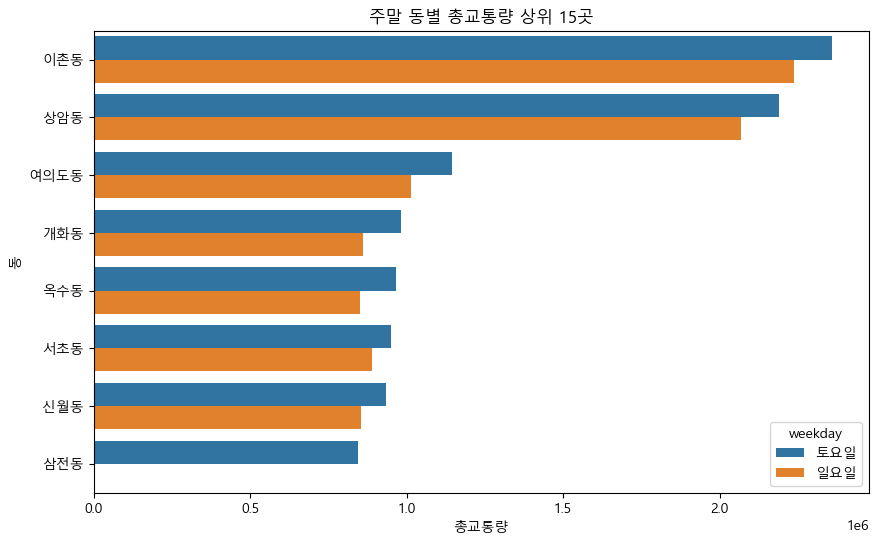

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

top_dong = region_summary.sort_values("Ï¥ùÍµêÌÜµÎüâ", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x="Ï¥ùÍµêÌÜµÎüâ", y="Îèô", hue="weekday", data=top_dong)
plt.title("Ï£ºÎßê ÎèôÎ≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏÉÅÏúÑ 15Í≥≥")
plt.show()


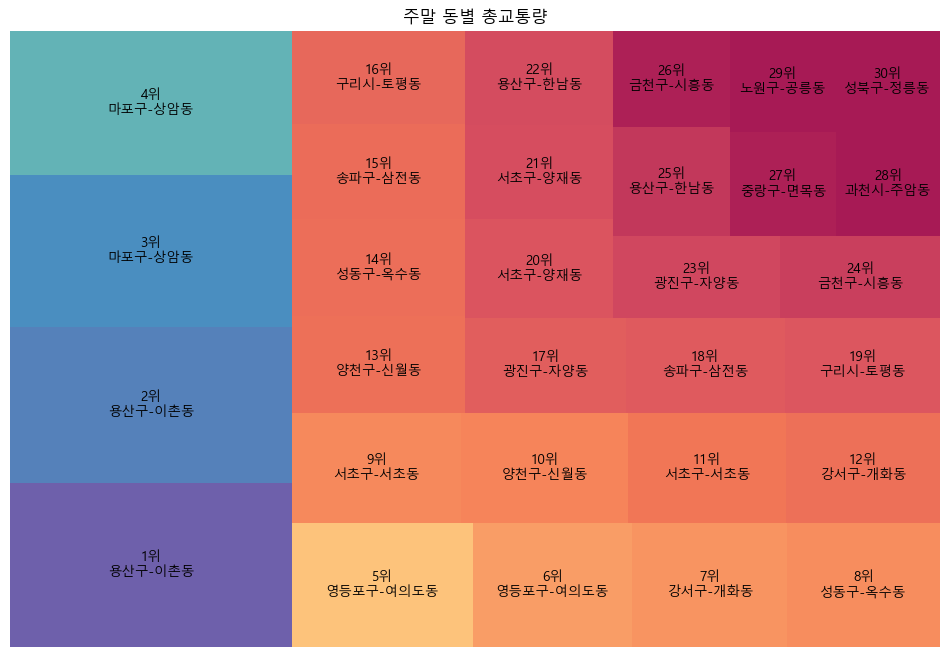

In [129]:
import squarify
import matplotlib.pyplot as plt
import numpy as np

top30 = region_summary.sort_values("Ï¥ùÍµêÌÜµÎüâ", ascending=False).head(30).copy()
top30["rank"] = range(1, len(top30)+1)
top30["ÎùºÎ≤®"] = top30["rank"].astype(str) + "ÏúÑ\n" + top30["Íµ¨"] + "-" + top30["Îèô"]

# Ïª¨Îü¨Îßµ Î∞îÍæ∏Í∏∞
norm_traffic = (top30["Ï¥ùÍµêÌÜµÎüâ"] - top30["Ï¥ùÍµêÌÜµÎüâ"].min()) / (top30["Ï¥ùÍµêÌÜµÎüâ"].max() - top30["Ï¥ùÍµêÌÜµÎüâ"].min())
colors = [plt.cm.Spectral(val) for val in norm_traffic]

plt.figure(figsize=(12,8))
squarify.plot(sizes=top30["Ï¥ùÍµêÌÜµÎüâ"], label=top30["ÎùºÎ≤®"], 
              color=colors, alpha=0.9,  text_kwargs={'fontsize':9.7}) #pad=True,
plt.axis('off')
plt.title("Ï£ºÎßê ÎèôÎ≥Ñ Ï¥ùÍµêÌÜµÎüâ")
plt.show()


In [126]:
region_summary

ÏßÄÏó≠      Ï¥ùÍµêÌÜµÎüâ
1  ÎÇ®ÏÑúÎ∂Ä  18695464
0  ÎÇ®ÎèôÎ∂Ä  17784352
3  Î∂ÅÏÑúÎ∂Ä  14570587
2  Î∂ÅÎèôÎ∂Ä  13828643

C:\Users\s2arora\AppData\Local\Temp\ipykernel_31008\2426294538.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top30_sorted["ÎùºÎ≤®"], x=top30_sorted["Ï¥ùÍµêÌÜµÎüâ"],


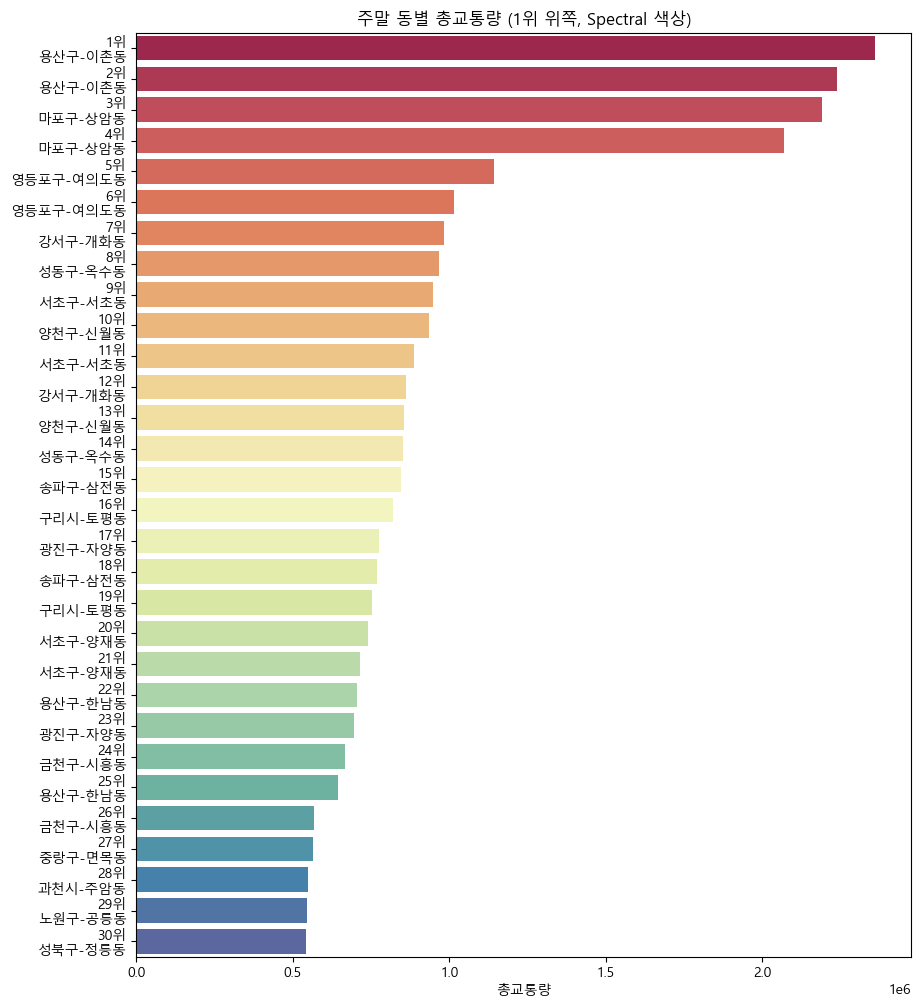

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# ÏàúÏúÑ ÎÜíÏùÄÍ≤å ÏúÑÎ°ú Ïò§Í≤å
top30_sorted = top30.sort_values("rank")

plt.figure(figsize=(10,12))
sns.barplot(y=top30_sorted["ÎùºÎ≤®"], x=top30_sorted["Ï¥ùÍµêÌÜµÎüâ"],
            palette=sns.color_palette("Spectral", n_colors=len(top30_sorted)))
plt.title("Ï£ºÎßê ÎèôÎ≥Ñ Ï¥ùÍµêÌÜµÎüâ (1ÏúÑ ÏúÑÏ™Ω, Spectral ÏÉâÏÉÅ)")
plt.xlabel("Ï¥ùÍµêÌÜµÎüâ")
plt.ylabel("")
plt.show()


In [84]:
region_summary

weekday   ÏßÄÏó≠    Íµ¨    Ï¥ùÍµêÌÜµÎüâ
65     ÌÜ†ÏöîÏùº  Î∂ÅÎèôÎ∂Ä  Íµ¨Î¶¨Ïãú  3767.0
44     ÌÜ†ÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  Í≥ºÏ≤úÏãú  3174.5
57     ÌÜ†ÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  ÎßàÌè¨Íµ¨  2603.0
49     ÌÜ†ÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  Ïö©ÏÇ∞Íµ¨  2374.0
78     ÌÜ†ÏöîÏùº  Î∂ÅÏÑúÎ∂Ä  ÎßàÌè¨Íµ¨  2341.0
..     ...  ...  ...     ...
41     ÏùºÏöîÏùº  Î∂ÅÏÑúÎ∂Ä   Ï§ëÍµ¨   369.0
17     ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  ÏÑúÏ¥àÍµ¨   365.0
22     ÏùºÏöîÏùº  Î∂ÅÎèôÎ∂Ä  Í¥ëÏßÑÍµ¨   351.0
1      ÏùºÏöîÏùº  ÎÇ®ÎèôÎ∂Ä  Í∞ïÎèôÍµ¨   330.0
11     ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  Í¥ëÎ™ÖÏãú    64.0

[84 rows x 4 columns]

C:\Users\s2arora\AppData\Local\Temp\ipykernel_31008\946172442.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_traffic, x="hour", y="Ï¥ùÍµêÌÜµÎüâ", palette="viridis")


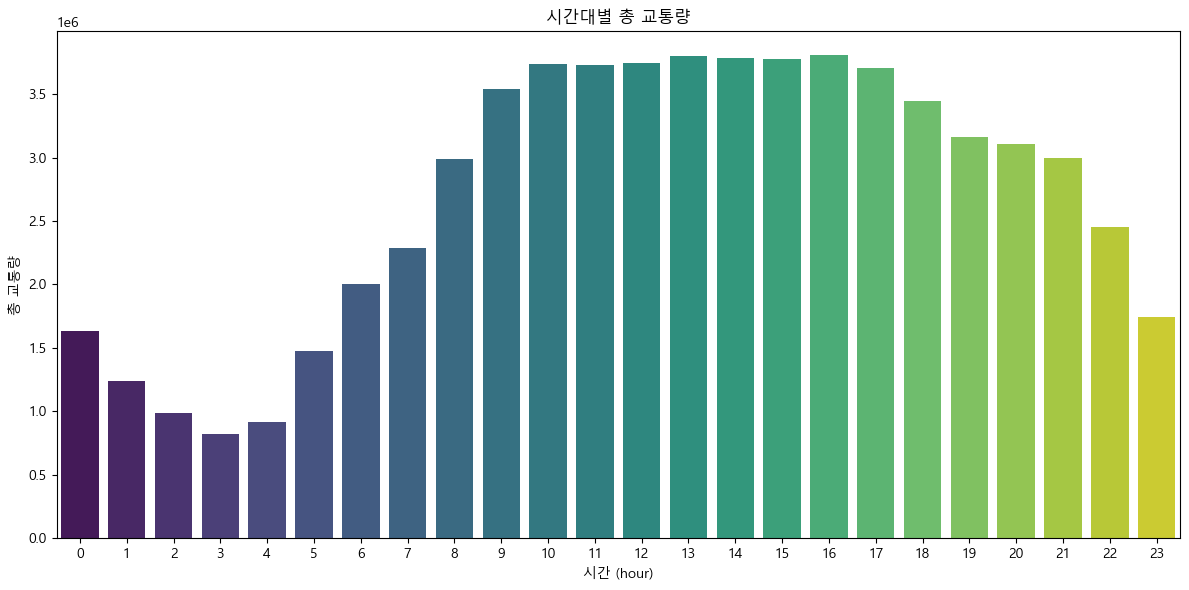

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# ÏãúÍ∞ÑÎ≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
hourly_traffic = df.groupby("hour")["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_traffic, x="hour", y="Ï¥ùÍµêÌÜµÎüâ", palette="viridis")
plt.title("ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï¥ù ÍµêÌÜµÎüâ")
plt.xlabel("ÏãúÍ∞Ñ (hour)")
plt.ylabel("Ï¥ù ÍµêÌÜµÎüâ")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\670680314.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=saturday_hourly, x="hour", y="Ï¥ùÍµêÌÜµÎüâ", palette="Blues")
C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\670680314.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sunday_hourly, x="hour", y="Ï¥ùÍµêÌÜµÎüâ", palette="Oranges")


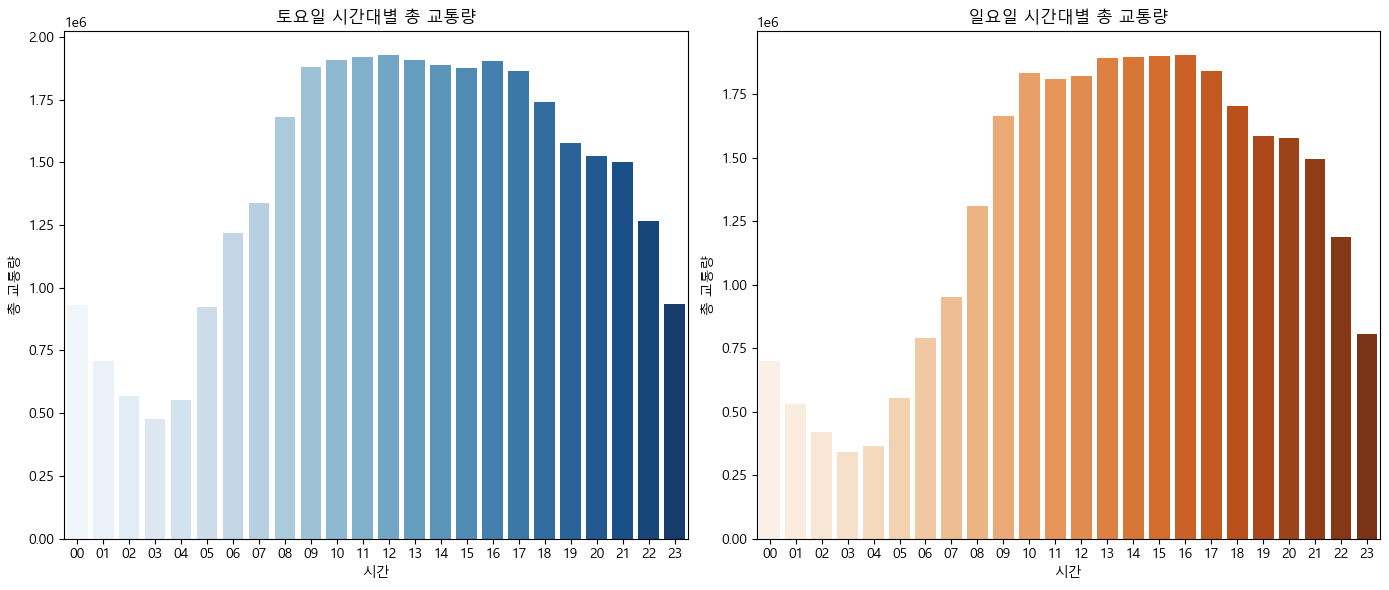

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÎÇ†Ïßú Ïª¨ÎüºÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞
saturday_df = df[df["weekday"] == "Saturday"]
sunday_df = df[df["weekday"] == "Sunday"]

# ÏãúÍ∞ÑÎ≥Ñ Ï¥ùÍµêÌÜµÎüâ ÏßëÍ≥Ñ
saturday_hourly = saturday_df.groupby("hour")["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
sunday_hourly = sunday_df.groupby("hour")["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14, 6))

# ÌÜ†ÏöîÏùº Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 1)
sns.barplot(data=saturday_hourly, x="hour", y="Ï¥ùÍµêÌÜµÎüâ", palette="Blues")
plt.title("ÌÜ†ÏöîÏùº ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï¥ù ÍµêÌÜµÎüâ")
plt.xlabel("ÏãúÍ∞Ñ")
plt.ylabel("Ï¥ù ÍµêÌÜµÎüâ")

# ÏùºÏöîÏùº Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 2)
sns.barplot(data=sunday_hourly, x="hour", y="Ï¥ùÍµêÌÜµÎüâ", palette="Oranges")
plt.title("ÏùºÏöîÏùº ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï¥ù ÍµêÌÜµÎüâ")
plt.xlabel("ÏãúÍ∞Ñ")
plt.ylabel("Ï¥ù ÍµêÌÜµÎüâ")

plt.tight_layout()
plt.show()


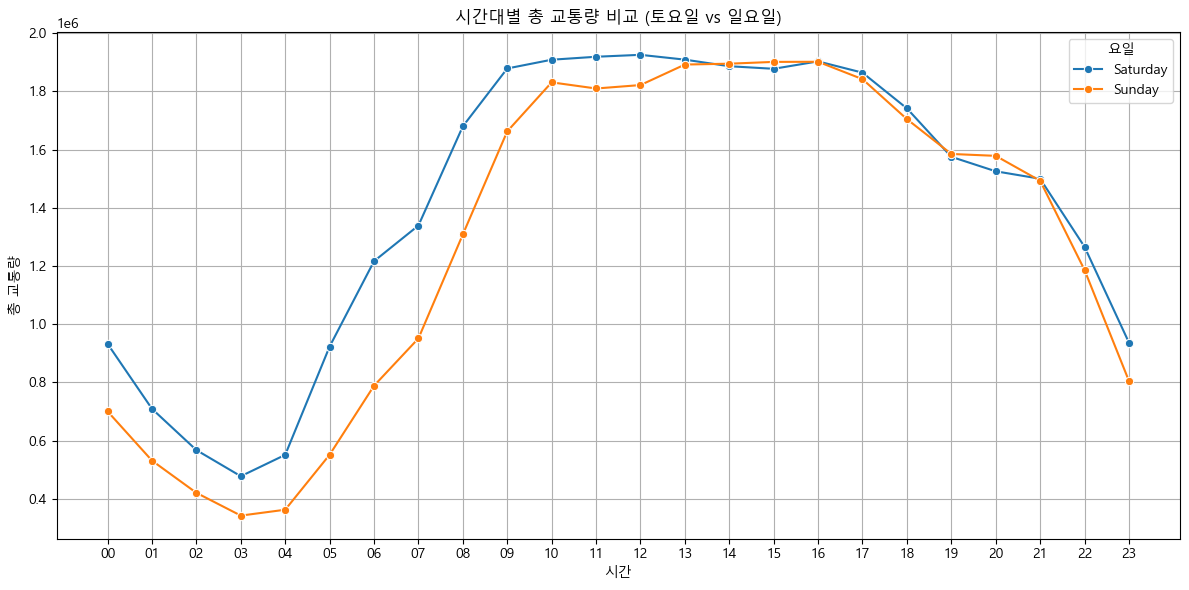

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò Î∞è ÏöîÏùº Ï∂îÍ∞Ä
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# ÌÜ†ÏöîÏùº/ÏùºÏöîÏùº Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]

# ÏãúÍ∞ÑÎåÄÎ≥Ñ, ÏöîÏùºÎ≥Ñ ÍµêÌÜµÎüâ ÏßëÍ≥Ñ
weekend_grouped = weekend_df.groupby(["weekday", "hour"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekend_grouped, x="hour", y="Ï¥ùÍµêÌÜµÎüâ", hue="weekday", marker='o')

plt.title("ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï¥ù ÍµêÌÜµÎüâ ÎπÑÍµê (ÌÜ†ÏöîÏùº vs ÏùºÏöîÏùº)")
plt.xlabel("ÏãúÍ∞Ñ")
plt.ylabel("Ï¥ù ÍµêÌÜµÎüâ")
plt.legend(title="ÏöîÏùº")
plt.grid(True)
plt.tight_layout()
plt.show()


In [115]:
weekend_df

date  hour    Íµ¨    Îèô   ÏßÄÏó≠     spot_name  inout  Ï¥ùÍµêÌÜµÎüâ  Íµ¨Î∂Ñ  \
0     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÇºÏÑ±Îèô  ÎÇ®ÎèôÎ∂Ä     ÌÖåÌó§ÎûÄÎ°ú(ÏÑ†Î¶âÏó≠)      1   942  Ïú†ÏûÖ   
1     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÇºÏÑ±Îèô  ÎÇ®ÎèôÎ∂Ä     ÌÖåÌó§ÎûÄÎ°ú(ÏÑ†Î¶âÏó≠)      2  1013  Ïú†Ï∂ú   
2     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä  Î∞§Í≥†Í∞úÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      1   177  Ïú†ÏûÖ   
3     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä  Î∞§Í≥†Í∞úÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      2   155  Ïú†Ï∂ú   
4     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä   ÌóåÎ¶âÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      1   330  Ïú†ÏûÖ   
...          ...   ...  ...  ...  ...           ...    ...   ...  ..   
49479 2025-04-27    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑ∏Ï¢ÖÎåÄÎ°ú(ÏÑúÏö∏Ïó≠)      2   655  Ïú†Ï∂ú   
49480 2025-04-27    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä      Ïπ†Ìå®Î°ú(Ïà≠Î°ÄÎ¨∏)      1    19  Ïú†ÏûÖ   
49481 2025-04-27    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä      Ïπ†Ìå®Î°ú(Ïà≠Î°ÄÎ¨∏)      2   480  Ïú†Ï∂ú   
49488 2025-04-27    23   Ï§ëÍµ¨   Ï†ïÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑúÏÜåÎ¨∏Î°ú(ÏãúÏ≤≠Ïó≠)      1   550  Ïú†ÏûÖ   
49489 2025-04-27    23   Ï§ëÍµ¨   Ï†ïÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑúÏÜåÎ¨∏Î°ú(ÏãúÏ≤≠Ïó≠)      2   444  Ïú†Ï∂ú   

        weekday weekday_eng  
0      Saturday    Saturday  
1      Saturday    Saturday  
2      Saturday    Saturday  
3      Saturday    Saturday  
4      Saturday    Saturday  
...         ...         ...  
49479    Sunday      Sunday  
49480    Sunday      Sunday  
49481    Sunday      Sunday  
49488    Sunday      Sunday  
49489    Sunday      Sunday  

[49500 rows x 11 columns]

C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\3147241673.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_sat, y="ÏßÄÏó≠", x="Ï¥ùÍµêÌÜµÎüâ", ax=axes[0], palette="Blues_d")
C:\Users\s2arora\AppData\Local\Temp\ipykernel_59416\3147241673.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_sun, y="ÏßÄÏó≠", x="Ï¥ùÍµêÌÜµÎüâ", ax=axes[1], palette="Oranges_d")


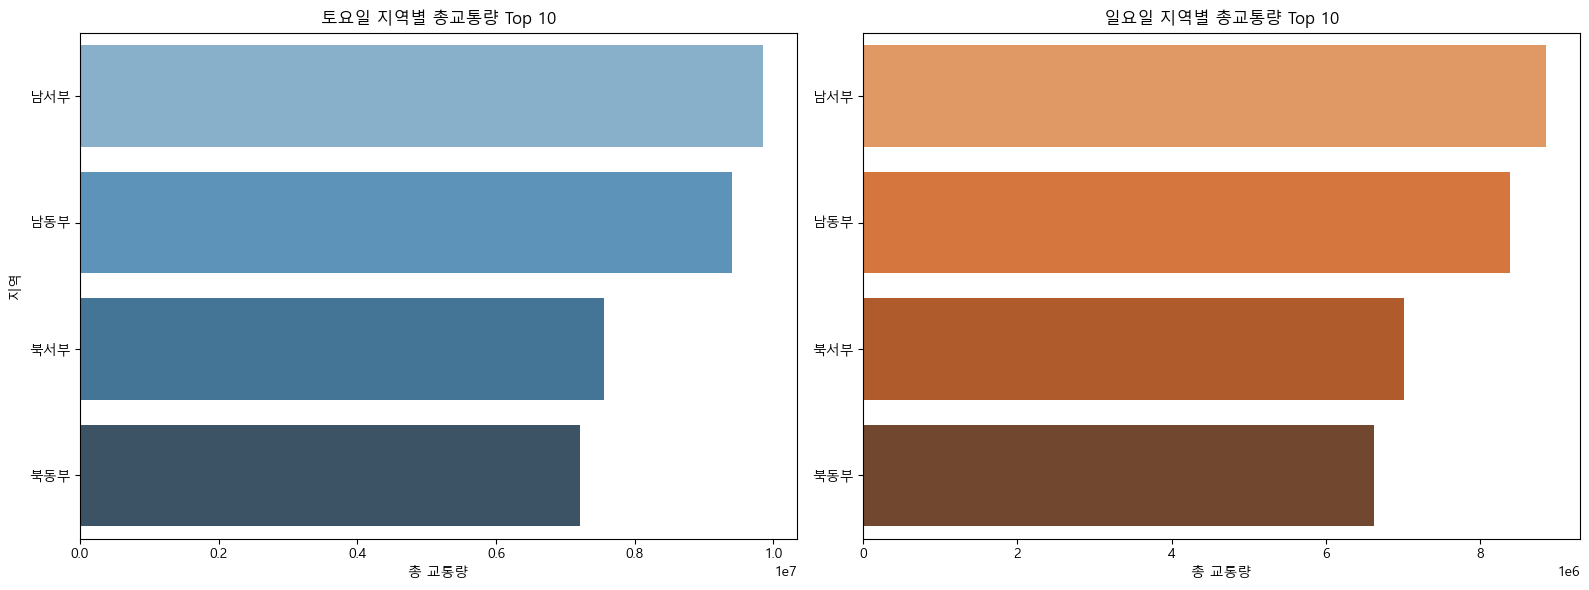

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÎÇ†ÏßúÌòïÏãùÍ≥º ÏöîÏùº Íµ¨ÌïòÍ∏∞
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# ÏöîÏùºÎ≥Ñ ÏßÄÏó≠Î≥Ñ ÍµêÌÜµÎüâ ÏßëÍ≥Ñ
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]
region_traffic = weekend_df.groupby(["weekday", "ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()

# ÏöîÏùºÎ≥Ñ TOP10 ÏßÄÏó≠ Ï∂îÏ∂ú
top10_sat = region_traffic[region_traffic["weekday"] == "Saturday"].sort_values("Ï¥ùÍµêÌÜµÎüâ", ascending=False).head(10)
top10_sun = region_traffic[region_traffic["weekday"] == "Sunday"].sort_values("Ï¥ùÍµêÌÜµÎüâ", ascending=False).head(10)

# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=top10_sat, y="ÏßÄÏó≠", x="Ï¥ùÍµêÌÜµÎüâ", ax=axes[0], palette="Blues_d")
axes[0].set_title("ÌÜ†ÏöîÏùº ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ Top 10")
axes[0].set_xlabel("Ï¥ù ÍµêÌÜµÎüâ")
axes[0].set_ylabel("ÏßÄÏó≠")

sns.barplot(data=top10_sun, y="ÏßÄÏó≠", x="Ï¥ùÍµêÌÜµÎüâ", ax=axes[1], palette="Oranges_d")
axes[1].set_title("ÏùºÏöîÏùº ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ Top 10")
axes[1].set_xlabel("Ï¥ù ÍµêÌÜµÎüâ")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


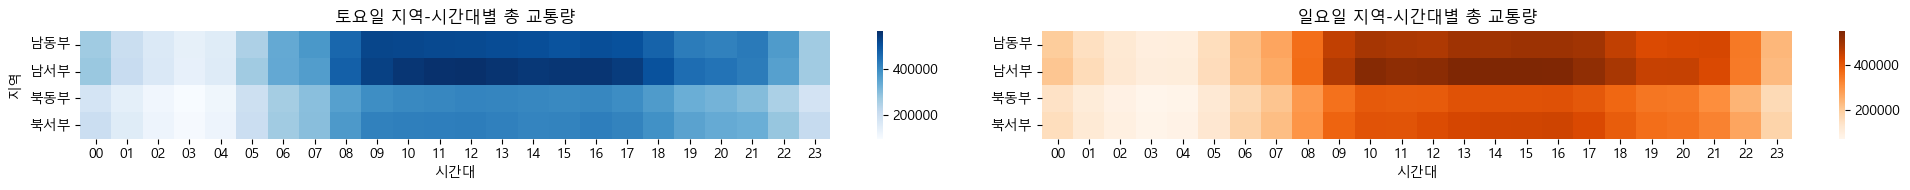

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ÎÇ†ÏßúÎ•º datetimeÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥† ÏöîÏùº Ï∂îÍ∞Ä
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday"] = df["date"].dt.day_name()

# Ï£ºÎßê Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]

# ÏöîÏùº, ÏßÄÏó≠, ÏãúÍ∞ÑÎåÄÎ≥ÑÎ°ú ÍµêÌÜµÎüâ ÏßëÍ≥Ñ
grouped = weekend_df.groupby(["weekday", "ÏßÄÏó≠", "hour"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()

# üîµ ÌÜ†ÏöîÏùº ÌîºÎ≤ó ÌÖåÏù¥Î∏î ÏÉùÏÑ± (Ìñâ: ÏßÄÏó≠, Ïó¥: ÏãúÍ∞ÑÎåÄ)
pivot_sat = grouped[grouped["weekday"] == "Saturday"].pivot(index="ÏßÄÏó≠", columns="hour", values="Ï¥ùÍµêÌÜµÎüâ").fillna(0)

# üü† ÏùºÏöîÏùº ÌîºÎ≤ó ÌÖåÏù¥Î∏î ÏÉùÏÑ±
pivot_sun = grouped[grouped["weekday"] == "Sunday"].pivot(index="ÏßÄÏó≠", columns="hour", values="Ï¥ùÍµêÌÜµÎüâ").fillna(0)

# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(20, len(pivot_sat)//2))

sns.heatmap(pivot_sat, cmap="Blues", ax=axes[0])
axes[0].set_title("ÌÜ†ÏöîÏùº ÏßÄÏó≠-ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï¥ù ÍµêÌÜµÎüâ")
axes[0].set_xlabel("ÏãúÍ∞ÑÎåÄ")
axes[0].set_ylabel("ÏßÄÏó≠")

sns.heatmap(pivot_sun, cmap="Oranges", ax=axes[1])
axes[1].set_title("ÏùºÏöîÏùº ÏßÄÏó≠-ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï¥ù ÍµêÌÜµÎüâ")
axes[1].set_xlabel("ÏãúÍ∞ÑÎåÄ")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# Ïò¨Î∞îÎ•∏ CSV ÌååÏùºÏùÑ ÏóÖÎ°úÎìúÌñàÎã§Í≥† Í∞ÄÏ†ïÌïòÍ≥† Î∂àÎü¨Ïò§Í∏∞
region_gb 

# Ïª¨ÎüºÎ™ÖÏù¥ ÏóÜÎäî ÏÉÅÌÉúÏùº Ïàò ÏûàÏúºÎØÄÎ°ú Ïó¥ Í∞úÏàò ÎßûÎäîÏßÄ ÌôïÏù∏ ÌõÑ ÏàòÎèô ÏßÄÏ†ï
if region_gb.shape[1] == 11:
    region_gb.columns = ['date', 'hour', 'Íµ¨', 'Îèô', 'ÏßÄÏó≠', 'spot_name', 'inout', 'Ï¥ùÍµêÌÜµÎüâ', 'x', 'y', 'Íµ¨Î∂Ñ']

# ÎÇ†Ïßú Ï≤òÎ¶¨ Î∞è ÏöîÏùº ÌååÏÉù
region_gb["date"] = pd.to_datetime(region_gb["date"], format="%Y%m%d", errors='coerce')
region_gb["weekday"] = region_gb["date"].dt.day_name()

# Ï£ºÎßêÎßå ÌïÑÌÑ∞ÎßÅ
weekend_df = region_gb[region_gb["weekday"].isin(["Saturday", "Sunday"])]

# ÏöîÏïΩ: ÏöîÏùºÎ≥Ñ, Íµ¨, Îèô, ÏßÄÏó≠Î≥Ñ Ï¥ùÍµêÌÜµÎüâ Ìï©Í≥Ñ
weekend_summary = weekend_df.groupby(["weekday", "Íµ¨", "Îèô", "ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()

# ÌÜ†ÏöîÏùº, ÏùºÏöîÏùº Î∂ÑÎ¶¨
saturday_table = weekend_summary[weekend_summary["weekday"] == "Saturday"].drop(columns="weekday")
sunday_table = weekend_summary[weekend_summary["weekday"] == "Sunday"].drop(columns="weekday")

print("‚úÖ ÌÜ†ÏöîÏùº ÍµêÌÜµÎüâ ÏÉÅÏúÑ 10Í∞ú")
print(saturday_table.sort_values("Ï¥ùÍµêÌÜµÎüâ", ascending=False).head(10))

print("\n‚úÖ ÏùºÏöîÏùº ÍµêÌÜµÎüâ ÏÉÅÏúÑ 10Í∞ú")
print(sunday_table.sort_values("Ï¥ùÍµêÌÜµÎüâ", ascending=False).head(10))


‚úÖ ÌÜ†ÏöîÏùº ÍµêÌÜµÎüâ ÏÉÅÏúÑ 10Í∞ú
       Íµ¨     Îèô   ÏßÄÏó≠     Ï¥ùÍµêÌÜµÎüâ
69   Ïö©ÏÇ∞Íµ¨   Ïù¥Ï¥åÎèô  ÎÇ®ÏÑúÎ∂Ä  2359041
39   ÎßàÌè¨Íµ¨   ÏÉÅÏïîÎèô  Î∂ÅÏÑúÎ∂Ä  2191630
66  ÏòÅÎì±Ìè¨Íµ¨  Ïó¨ÏùòÎèÑÎèô  ÎÇ®ÏÑúÎ∂Ä  1143602
5    Í∞ïÏÑúÍµ¨   Í∞úÌôîÎèô  Î∂ÅÏÑúÎ∂Ä   982728
53   ÏÑ±ÎèôÍµ¨   Ïò•ÏàòÎèô  ÎÇ®ÎèôÎ∂Ä   967434
48   ÏÑúÏ¥àÍµ¨   ÏÑúÏ¥àÎèô  ÎÇ®ÎèôÎ∂Ä   948708
63   ÏñëÏ≤úÍµ¨   Ïã†ÏõîÎèô  ÎÇ®ÏÑúÎ∂Ä   934305
60   ÏÜ°ÌååÍµ¨   ÏÇºÏ†ÑÎèô  ÎÇ®ÎèôÎ∂Ä   845740
27   Íµ¨Î¶¨Ïãú   ÌÜ†ÌèâÎèô  Î∂ÅÎèôÎ∂Ä   818769
20   Í¥ëÏßÑÍµ¨   ÏûêÏñëÎèô  ÎÇ®ÎèôÎ∂Ä   776104

‚úÖ ÏùºÏöîÏùº ÍµêÌÜµÎüâ ÏÉÅÏúÑ 10Í∞ú
        Íµ¨     Îèô   ÏßÄÏó≠     Ï¥ùÍµêÌÜµÎüâ
165   Ïö©ÏÇ∞Íµ¨   Ïù¥Ï¥åÎèô  ÎÇ®ÏÑúÎ∂Ä  2238993
135   ÎßàÌè¨Íµ¨   ÏÉÅÏïîÎèô  Î∂ÅÏÑúÎ∂Ä  2067992
162  ÏòÅÎì±Ìè¨Íµ¨  Ïó¨ÏùòÎèÑÎèô  ÎÇ®ÏÑúÎ∂Ä  1013859
144   ÏÑúÏ¥àÍµ¨   ÏÑúÏ¥àÎèô  ÎÇ®ÎèôÎ∂Ä   888456
101   Í∞ïÏÑúÍµ¨   Í∞úÌôîÎèô  Î∂ÅÏÑúÎ∂Ä   861013
159   ÏñëÏ≤úÍµ¨   Ïã†ÏõîÎèô  ÎÇ®ÏÑúÎ∂Ä   855574
149   ÏÑ±ÎèôÍµ¨   Ïò•ÏàòÎèô  ÎÇ®ÎèôÎ∂Ä   850338
156   ÏÜ°ÌååÍµ¨   ÏÇ

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ‚úÖ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df_wk =region_gb
# ‚úÖ ÎÇ†Ïßú ‚Üí datetime Î≥ÄÌôò, ÏöîÏùº Ï∂îÍ∞Ä
df_wk["date"] = pd.to_datetime(df_wk["date"], format="%Y%m%d")
df_wk["ÏöîÏùº"] = df_wk["date"].dt.day_name(locale="ko_KR")


In [12]:
# ‚úÖ ÏöîÏùºÎ≥Ñ directionÎ≥Ñ Î≥ºÎ•® Ï¥ùÌï©
ÏöîÏùºÎ≥Ñ_ÏµúÎã§ = (
    df_wk.groupby(["ÏöîÏùº", "ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
    .sort_values(["ÏöîÏùº", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[True, False])
    .groupby("ÏöîÏùº").head(1)
)

print("üìå Ï£ºÎßê ÏöîÏùºÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:")
print(ÏöîÏùºÎ≥Ñ_ÏµúÎã§)


üìå Ï£ºÎßê ÏöîÏùºÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:
    ÏöîÏùº   ÏßÄÏó≠     Ï¥ùÍµêÌÜµÎüâ
1  ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  8851271
5  ÌÜ†ÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  9844193


In [17]:
# ‚úÖ ÏöîÏùºÎ≥Ñ directionÎ≥Ñ Î≥ºÎ•® Ï¥ùÌï©
ÏöîÏùºÎ≥Ñ_ÏµúÎã§ = (
    df_wk.groupby(["ÏöîÏùº", "ÏßÄÏó≠","Íµ¨"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
    .sort_values(["ÏöîÏùº", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[True, False])
    .groupby("ÏöîÏùº").head(1)
)

print("üìå Ï£ºÎßê ÏöîÏùºÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:")
print(ÏöîÏùºÎ≥Ñ_ÏµúÎã§)

üìå Ï£ºÎßê ÏöîÏùºÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:
     ÏöîÏùº   ÏßÄÏó≠    Íµ¨     Ï¥ùÍµêÌÜµÎüâ
20  ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  2557064
62  ÌÜ†ÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  2704970


In [16]:
# ‚úÖ ÏöîÏùºÎ≥Ñ directionÎ≥Ñ Î≥ºÎ•® Ï¥ùÌï©
ÏöîÏùºÎ≥Ñ_ÏµúÎã§ = (
    df_wk.groupby(["ÏöîÏùº","ÏßÄÏó≠", "Íµ¨", "Îèô" ])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
    .sort_values(["ÏöîÏùº", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[True, False])
    .groupby("ÏöîÏùº").head(1)
)

print("üìå Ï£ºÎßê ÏöîÏùºÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:")
print(ÏöîÏùºÎ≥Ñ_ÏµúÎã§)

üìå Ï£ºÎßê ÏöîÏùºÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:
      ÏöîÏùº   ÏßÄÏó≠    Íµ¨    Îèô     Ï¥ùÍµêÌÜµÎüâ
46   ÏùºÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  2238993
142  ÌÜ†ÏöîÏùº  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  2359041


In [18]:
# ‚úÖ ÏãúÍ∞ÑÎ≥Ñ directionÎ≥Ñ Î≥ºÎ•® Ï¥ùÌï©
ÏãúÍ∞ÑÎ≥Ñ_ÏµúÎã§ = (
    df_wk.groupby(["hour", "ÏßÄÏó≠"])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
    .sort_values(["hour", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[True, False])
    .groupby("hour").head(1)
)

print("üìå Ï£ºÎßê ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:")
print(ÏãúÍ∞ÑÎ≥Ñ_ÏµúÎã§)


üìå Ï£ºÎßê ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:
   hour   ÏßÄÏó≠     Ï¥ùÍµêÌÜµÎüâ
1    00  ÎÇ®ÏÑúÎ∂Ä   484410
5    01  ÎÇ®ÏÑúÎ∂Ä   368500
9    02  ÎÇ®ÏÑúÎ∂Ä   290832
13   03  ÎÇ®ÏÑúÎ∂Ä   237922
17   04  ÎÇ®ÏÑúÎ∂Ä   262421
21   05  ÎÇ®ÏÑúÎ∂Ä   424503
24   06  ÎÇ®ÎèôÎ∂Ä   562164
28   07  ÎÇ®ÎèôÎ∂Ä   642628
33   08  ÎÇ®ÏÑúÎ∂Ä   843940
37   09  ÎÇ®ÏÑúÎ∂Ä  1008771
41   10  ÎÇ®ÏÑúÎ∂Ä  1089652
45   11  ÎÇ®ÏÑúÎ∂Ä  1088890
49   12  ÎÇ®ÏÑúÎ∂Ä  1094158
53   13  ÎÇ®ÏÑúÎ∂Ä  1104691
57   14  ÎÇ®ÏÑúÎ∂Ä  1099064
61   15  ÎÇ®ÏÑúÎ∂Ä  1101309
65   16  ÎÇ®ÏÑúÎ∂Ä  1102074
69   17  ÎÇ®ÏÑúÎ∂Ä  1063520
73   18  ÎÇ®ÏÑúÎ∂Ä   990897
77   19  ÎÇ®ÏÑúÎ∂Ä   906311
81   20  ÎÇ®ÏÑúÎ∂Ä   895749
84   21  ÎÇ®ÎèôÎ∂Ä   864122
88   22  ÎÇ®ÎèôÎ∂Ä   712632
92   23  ÎÇ®ÎèôÎ∂Ä   502466


In [19]:
# ‚úÖ ÏãúÍ∞ÑÎ≥Ñ directionÎ≥Ñ Î≥ºÎ•® Ï¥ùÌï©
ÏãúÍ∞ÑÎ≥Ñ_ÏµúÎã§ = (
    df_wk.groupby(["hour", "ÏßÄÏó≠",'Íµ¨'])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
    .sort_values(["hour", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[True, False])
    .groupby("hour").head(1)
)

print("üìå Ï£ºÎßê ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:")
print(ÏãúÍ∞ÑÎ≥Ñ_ÏµúÎã§)


üìå Ï£ºÎßê ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:
    hour   ÏßÄÏó≠    Íµ¨    Ï¥ùÍµêÌÜµÎüâ
20    00  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  156112
62    01  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  113934
104   02  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨   91479
146   03  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨   74734
188   04  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨   86002
230   05  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  136549
256   06  ÎÇ®ÎèôÎ∂Ä  ÏÑúÏ¥àÍµ¨  181947
298   07  ÎÇ®ÎèôÎ∂Ä  ÏÑúÏ¥àÍµ¨  195446
356   08  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  254144
398   09  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  287091
440   10  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  287675
482   11  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  288616
524   12  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  285594
566   13  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  281070
608   14  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  276041
650   15  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  276057
692   16  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  278248
734   17  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  271849
776   18  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  261610
818   19  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  254738
860   20  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  262760
902   21  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  268976
944   22  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  230054
986   23  ÎÇ®ÏÑ

In [20]:
# ‚úÖ ÏãúÍ∞ÑÎ≥Ñ directionÎ≥Ñ Î≥ºÎ•® Ï¥ùÌï©
ÏãúÍ∞ÑÎ≥Ñ_ÏµúÎã§ = (
    df_wk.groupby(["hour", "ÏßÄÏó≠",'Íµ¨','Îèô'])["Ï¥ùÍµêÌÜµÎüâ"].sum().reset_index()
    .sort_values(["hour", "Ï¥ùÍµêÌÜµÎüâ"], ascending=[True, False])
    .groupby("hour").head(1)
)

print("üìå Ï£ºÎßê ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:")
print(ÏãúÍ∞ÑÎ≥Ñ_ÏµúÎã§)


üìå Ï£ºÎßê ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏµúÎã§ ÌòºÏû° Î∞©Ìñ•:
     hour   ÏßÄÏó≠    Íµ¨    Îèô    Ï¥ùÍµêÌÜµÎüâ
46     00  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  135881
142    01  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô   99393
238    02  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô   79521
334    03  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô   65243
430    04  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô   76309
526    05  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  122666
622    06  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  160620
718    07  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  171253
814    08  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  222777
910    09  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  248754
1006   10  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  251122
1102   11  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  250774
1198   12  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  248575
1294   13  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  243467
1390   14  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  239437
1486   15  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  240051
1582   16  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï¥åÎèô  242675
1678   17  ÎÇ®ÏÑúÎ∂Ä  Ïö©ÏÇ∞Íµ¨  Ïù¥Ï

In [121]:
df

date  hour    Íµ¨    Îèô   ÏßÄÏó≠     spot_name  inout  Ï¥ùÍµêÌÜµÎüâ  Íµ¨Î∂Ñ  \
0     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÇºÏÑ±Îèô  ÎÇ®ÎèôÎ∂Ä     ÌÖåÌó§ÎûÄÎ°ú(ÏÑ†Î¶âÏó≠)      1   942  Ïú†ÏûÖ   
1     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÇºÏÑ±Îèô  ÎÇ®ÎèôÎ∂Ä     ÌÖåÌó§ÎûÄÎ°ú(ÏÑ†Î¶âÏó≠)      2  1013  Ïú†Ï∂ú   
2     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä  Î∞§Í≥†Í∞úÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      1   177  Ïú†ÏûÖ   
3     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä  Î∞§Í≥†Í∞úÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      2   155  Ïú†Ï∂ú   
4     2025-04-05     0  Í∞ïÎÇ®Íµ¨  ÏÑ∏Í≥°Îèô  ÎÇ®ÎèôÎ∂Ä   ÌóåÎ¶âÎ°ú(ÏÑ∏Í≥°ÎèôÏÇ¨Í±∞Î¶¨)      1   330  Ïú†ÏûÖ   
...          ...   ...  ...  ...  ...           ...    ...   ...  ..   
49479 2025-04-27    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑ∏Ï¢ÖÎåÄÎ°ú(ÏÑúÏö∏Ïó≠)      2   655  Ïú†Ï∂ú   
49480 2025-04-27    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä      Ïπ†Ìå®Î°ú(Ïà≠Î°ÄÎ¨∏)      1    19  Ïú†ÏûÖ   
49481 2025-04-27    23   Ï§ëÍµ¨  ÏàúÌôîÎèô  Î∂ÅÏÑúÎ∂Ä      Ïπ†Ìå®Î°ú(Ïà≠Î°ÄÎ¨∏)      2   480  Ïú†Ï∂ú   
49488 2025-04-27    23   Ï§ëÍµ¨   Ï†ïÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑúÏÜåÎ¨∏Î°ú(ÏãúÏ≤≠Ïó≠)      1   550  Ïú†ÏûÖ   
49489 2025-04-27    23   Ï§ëÍµ¨   Ï†ïÎèô  Î∂ÅÏÑúÎ∂Ä     ÏÑúÏÜåÎ¨∏Î°ú(ÏãúÏ≤≠Ïó≠)      2   444  Ïú†Ï∂ú   

        weekday weekday_eng  
0      Saturday    Saturday  
1      Saturday    Saturday  
2      Saturday    Saturday  
3      Saturday    Saturday  
4      Saturday    Saturday  
...         ...         ...  
49479    Sunday      Sunday  
49480    Sunday      Sunday  
49481    Sunday      Sunday  
49488    Sunday      Sunday  
49489    Sunday      Sunday  

[49500 rows x 11 columns]